## 1. 고객 정보

In [1]:
import pandas as pd

# --- 파일 경로 정의 ---
# 각 엑셀 파일의 실제 위치에 맞게 경로를 수정해주세요.
household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'
# 'r설문지 응답' 시트가 포함된 원본 엑셀 파일의 경로를 지정해야 합니다.
# (업로드된 파일 목록에서는 이 파일의 원본 .xlsx가 아닌 CSV만 확인되므로,
# 실제 실행 환경에 원본 파일이 있다고 가정하고 경로를 작성했습니다.)
retirement_model_file_path = '손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx'

try:
    # --- 데이터 추출 ---

    # 1. 가계부 엑셀 파일에서 정보 가져오기
    # 파일: 손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm
    # 시트: 뱅샐현황
    df_household = pd.read_excel(household_file_path, sheet_name='뱅샐현황', header=None, engine='openpyxl')
    
    # iloc[row, column]를 사용하여 특정 셀 값 추출 (0부터 시작)
    age = df_household.iloc[5, 3]      # D6 셀
    gender = df_household.iloc[5, 2]   # C6 셀
    credit_score = df_household.iloc[5, 4] # E6 셀


    # 2. 은퇴설계 모델 엑셀 파일에서 직업 정보 가져오기
    # 파일: 손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx
    # 시트: r설문지 응답
    # 엑셀의 특정 시트를 직접 읽도록 수정했습니다.
    df_retirement_survey = pd.read_excel(retirement_model_file_path, sheet_name='r설문지 응답', header=None)

    # C12 셀에 해당하는 데이터 추출
    job = df_retirement_survey.iloc[11, 3] # C열(2), 12번째 행(11)


    # --- client_profile 딕셔너리 생성 ---
    
    client_profile = {
        "고객정보": {
            "고객명": "넉넉한 윤리쌤",
            "나이": age,
            "직업": job,
            "성별": gender,
            "신용점수": credit_score
        }
    }

    # --- 결과 확인 ---
    print("✅ '고객정보' 생성이 완료되었습니다. (수정 완료)")
    
    import json
    print(json.dumps(client_profile, ensure_ascii=False, indent=4))

except FileNotFoundError as e:
    # 사용자가 원본 .xlsx 파일을 업로드하지 않았을 경우를 대비한 안내
    print(f"오류: 파일을 찾을 수 없습니다.")
    print(f"지정한 경로에 '{e.filename}' 파일이 있는지 확인해주세요.")
    print("특히 '손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx' 파일이 필요합니다.")
    
except ValueError as e:
    # 엑셀에 해당 시트가 없을 경우 발생하는 오류 처리
    if "Worksheet" in str(e) and "not found" in str(e):
        print(f"오류: 엑셀 파일 안에 '{retirement_model_file_path}' 시트가 없습니다. 시트 이름을 확인해주세요.")
    else:
        print(f"데이터를 읽는 중 오류가 발생했습니다: {e}")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd

# --- 이전 단계 코드 실행으로 client_profile이 생성되어 있다고 가정합니다. ---
# 만약 이 스크립트를 단독으로 실행한다면, 아래 주석을 해제하여 client_profile을 생성해주세요.
# client_profile = {"고객정보": {}}


# --- 파일 경로 정의 ---
household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'

try:
    # --- 데이터 불러오기 및 전처리 ---
    df = pd.read_excel(household_file_path, sheet_name='가계부 내역', engine='openpyxl')
    
    # '거래일' 컬럼을 날짜 형식으로 변환 (오류 발생 시 무시)
    df['거래일'] = pd.to_datetime(df['거래일'], errors='coerce')
    # 날짜 형식이 아닌 데이터 제거
    df.dropna(subset=['거래일'], inplace=True)

    # --- 분석 기준월('이번 달') 결정 ---
    latest_date = df['거래일'].max()
    # is_month_end는 해당 월의 마지막 날인지 확인하는 pandas 기능입니다.
    if latest_date.is_month_end:
        analysis_month_period = pd.Period(latest_date, freq='M')
    else:
        # 월말이 아니면, 한 달을 뺀다.
        analysis_month_period = pd.Period(latest_date, freq='M') - 1
    
    print(f"알림: 데이터의 최근 날짜는 {latest_date.strftime('%Y-%m-%d')} 입니다.")
    print(f"알림: 분석 기준월('이번 달')은 '{analysis_month_period.strftime('%Y년 %m월')}' 입니다.")

    # --- 최근 3개월간 월별 데이터 계산 ---
    monthly_summary = []
    for i in range(3):
        target_month = analysis_month_period - i
        
        # 해당 월의 데이터 필터링
        df_month = df[df['거래일'].dt.to_period('M') == target_month]

        # 1. 수입 계산
        income = df_month[df_month['pv_대분류'] == '수입']['pv_지출액'].sum()
        
        # 2. 지출 계산 (지출 - 이체)
        spend_total = df_month[df_month['pv_대분류'] == '지출']['pv_지출액'].sum()
        transfer_total = df_month[df_month['pv_대분류'] == '이체']['pv_지출액'].sum()
        expenditure = spend_total + transfer_total
        
        # 3. 저축/투자 계산
        investment = df_month[df_month['pv_대분류'] == '저축/투자']['pv_지출액'].sum()

        # 4. 현금(여윳돈)
        cash_surplus = income - (expenditure + investment) + investment

        monthly_summary.append({
            "month": target_month,
            "income": income,
            "expenditure": expenditure,
            "investment": investment,
            "cash_surplus" : cash_surplus
        })

    # --- 최종 지표 계산 ---
    # 1) ~ 4) '이번 달' 현황
    this_month_data = monthly_summary[0]
    this_month_income = this_month_data['income']
    this_month_expenditure = this_month_data['expenditure']
    this_month_investment = this_month_data['investment']


    # 현금(여윳돈) = 수입 - (지출 + 저축/투자)
    this_month_cash_surplus = this_month_income - (this_month_expenditure + this_month_investment) + this_month_investment

    # 5) ~ 8) 3개월 평균 현황
    avg_income = sum(item['income'] for item in monthly_summary) / 3
    avg_expenditure = sum(item['expenditure'] for item in monthly_summary) / 3
    avg_investment = sum(item['investment'] for item in monthly_summary) / 3
    avg_cash_surplus = sum(item['cash_surplus'] for item in monthly_summary) / 3

    # 평균 순수입 = 평균 수입 - 평균 지출
    avg_net_income = avg_income - avg_expenditure

    # --- client_profile 딕셔너리에 추가 ---
    client_profile['수입/지출/투자 현황'] = {
        "분석 기준월": analysis_month_period.strftime('%Y-%m'),
        "이번 달 수입": f"{this_month_income:,.0f}원",
        "이번 달 지출": f"{this_month_expenditure:,.0f}원",
        "이번 달 저축/투자": f"{this_month_investment:,.0f}원",
        "이번 달 현금(여윳돈)": f"{this_month_cash_surplus:,.0f}원",
        "최근 3개월 평균 수입": f"{avg_income:,.0f}원",
        "최근 3개월 평균 지출": f"{avg_expenditure:,.0f}원",
        "최근 3개월 평균 순수입": f"{avg_net_income:,.0f}원",
        "최근 3개월 평균 저축/투자": f"{avg_investment:,.0f}원",
        "최근 3개월 평균 현금(여윳돈)" : f"{avg_cash_surplus:,.0f}원"
    }

    # --- 결과 확인 ---
    print("\n✅ '수입/지출/투자 현황' 생성이 완료되었습니다.")
    import json
    print(json.dumps(client_profile, ensure_ascii=False, indent=4))

except FileNotFoundError:
    print(f"오류: '{household_file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except KeyError as e:
    print(f"오류: 엑셀 시트에서 필요한 컬럼({e})을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd

# --- 이전 단계 코드 실행으로 client_profile, df, analysis_month_period 변수가 생성되어 있다고 가정합니다. ---

try:
    # --- 최종 데이터를 담을 딕셔너리 초기화 ---
    monthly_cash_flow_final = {}

    # --- 최근 6개월간 월별로 데이터 처리 ---
    for i in range(6):
        # 역순으로 6개월간의 월을 하나씩 가져옴 (예: 5월 -> 4월 -> 3월...)
        target_month_period = analysis_month_period - i
        month_str = target_month_period.strftime('%Y-%m')
        
        # 해당 월의 데이터만 필터링
        df_month = df[df['거래일'].dt.to_period('M') == target_month_period]

        # --- 1. 대분류별 총합 계산 ---
        income_total = df_month[df_month['pv_대분류'] == '수입']['pv_지출액'].sum()
        spend_total = df_month[df_month['pv_대분류'] == '지출']['pv_지출액'].sum()
        transfer_total = df_month[df_month['pv_대분류'] == '이체']['pv_지출액'].sum()
        investment_total = df_month[df_month['pv_대분류'] == '저축/투자']['pv_지출액'].sum()

        # --- 2. 중분류 상세 내역 계산 ---
        income_details = df_month[df_month['pv_대분류'] == '수입'].groupby('pv_중분류')['pv_지출액'].sum().to_dict()
        spend_details = df_month[df_month['pv_대분류'].isin(['지출', '이체'])].groupby('pv_중분류')['pv_지출액'].sum().to_dict()
        investment_details = df_month[df_month['pv_대분류'] == '저축/투자'].groupby('pv_중분류')['pv_지출액'].sum().to_dict()

        # --- 3. 해당 월의 최종 데이터 구조 조립 ---
        month_data = {
            "수입": {
                "총합": income_total,
                "상세내역": {k: v for k, v in sorted(income_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "총지출(이체포함)": {
                "총합": spend_total + transfer_total,
                "상세내역": {k: v for k, v in sorted(spend_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "저축/투자": {
                "총합": investment_total,
                "상세내역": {k: v for k, v in sorted(investment_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "순현금흐름(여윳돈)": income_total - (spend_total + transfer_total + investment_total) + investment_total
        }
        
        # --- 4. [특별 처리] '이번 달'에만 '소분류' 데이터 추가 ---
        if target_month_period == analysis_month_period:
            # '총지출(이체포함)'의 중분류 항목들에 대해 소분류 내역 추가
            spend_details_with_small = {}
            for mid_category, mid_total in month_data["총지출(이체포함)"]["상세내역"].items():
                small_category_details = df_month[df_month['pv_중분류'] == mid_category] \
                                         .groupby('pv_소분류')['pv_지출액'].sum().to_dict()
                
                spend_details_with_small[mid_category] = {
                    "총합": mid_total,
                    "소분류 상세": {k: v for k, v in sorted(small_category_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
                }
            # 기존 상세내역을 소분류가 포함된 상세내역으로 교체
            month_data["총지출(이체포함)"]["상세내역"] = spend_details_with_small
        
            # [수정된 부분] '저축/투자'의 중분류 항목들에 대해 소분류 내역 추가
            investment_details_with_small = {}
            if month_data["저축/투자"]["상세내역"]:
                for mid_category, mid_total in month_data["저축/투자"]["상세내역"].items():
                    small_category_details = df_month[
                        (df_month['pv_대분류'] == '저축/투자') &
                        (df_month['pv_중분류'] == mid_category)
                    ].groupby('pv_소분류')['pv_지출액'].sum().to_dict()

                    investment_details_with_small[mid_category] = {
                        "총합": mid_total,
                        "소분류 상세": {k: v for k, v in sorted(small_category_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
                    }
                # 기존 상세내역을 소분류가 포함된 상세내역으로 교체
                month_data["저축/투자"]["상세내역"] = investment_details_with_small
        
        # 최종 딕셔너리에 해당 월의 데이터를 추가
        monthly_cash_flow_final[month_str] = month_data


    # --- client_profile 딕셔너리에 추가 ---
    # 월별로 정렬하여 최종 저장
    client_profile['월별 현금흐름 요약'] = dict(sorted(monthly_cash_flow_final.items()))

    # --- 결과 확인 ---
    print("\n✅ '월별 현금흐름 요약 (최종 수정 버전)' 생성이 완료되었습니다.")
    
    import json
    # 전체 6개월 데이터가 모두 포함된 것을 확인
    print(json.dumps(client_profile['월별 현금흐름 요약'], ensure_ascii=False, indent=4, default=str))

except NameError as e:
    print(f"오류: 이전 단계의 변수({e})가 필요합니다. 이전 코드들을 먼저 실행해주세요.")
except KeyError as e:
    print(f"오류: 엑셀 시트에서 필요한 컬럼({e})을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd
import numpy as np

# --- 이전 단계 코드 실행으로 client_profile이 생성되어 있다고 가정합니다. ---

try:
    # --- 1. 데이터 불러오기 및 동적 범위 탐색 ---
    household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'
    df = pd.read_excel(household_file_path, sheet_name='뱅샐현황', header=None, engine='openpyxl')
    
    col_b = df.iloc[:, 1].astype(str)
    start_row_series = col_b[col_b.str.contains("자유입출금 자산", na=False)]
    end_row_series = col_b[col_b.str.contains("연금 자산", na=False)]

    if start_row_series.empty or end_row_series.empty:
        raise ValueError("자산/부채 테이블의 시작('자유입출금 자산') 또는 끝('연금 자산') 위치를 찾을 수 없어 중단합니다.")
    
    start_row = start_row_series.index[0]
    end_row = end_row_series.index[0]

    # --- 2. 데이터 테이블 슬라이싱 및 전처리 ---
    df_table = df.iloc[start_row:end_row + 1].copy()
    df_table.iloc[:, 1] = df_table.iloc[:, 1].ffill() # 자산 중분류 병합 처리
    df_table.iloc[:, 5] = df_table.iloc[:, 5].ffill() # 부채 중분류 병합 처리

    # --- 3. 자산/부채 상세 데이터 구조화 ---
    assets_dict = {}
    liability_dict = {}

    # 자산 처리 (B, C, E 열)
    asset_data = df_table[[1, 2, 4]].dropna(subset=[2])
    for index, row in asset_data.iterrows():
        mid_category, product_name, amount_raw = row[1], row[2], row[4]
        amount = pd.to_numeric(amount_raw, errors='coerce')
        if pd.notna(amount) and amount > 0:
            assets_dict.setdefault(mid_category, {})[product_name] = amount

    # 부채 처리 (F, G, I 열)
    liability_data = df_table[[5, 6, 8]].dropna(subset=[6])
    for index, row in liability_data.iterrows():
        mid_category, product_name, amount_raw = row[5], row[6], row[8]
        amount = pd.to_numeric(amount_raw, errors='coerce')
        if pd.notna(amount) and amount > 0:
            liability_dict.setdefault(mid_category, {})[product_name] = amount

    # --- 4. [핵심 수정] 상세 내역을 합산하여 총계 계산 ---
    # 각 중분류 딕셔너리의 모든 금액(value)들을 합산
    total_assets_val = sum(sum(v.values()) for v in assets_dict.values())
    total_liability_val = sum(sum(v.values()) for v in liability_dict.values())
    net_assets_val = total_assets_val - total_liability_val

    # --- 5. client_profile에 최종 데이터 추가 ---
    client_profile['자산/부채 현황'] = {
        "총자산": total_assets_val,
        "총부채": total_liability_val,
        "순자산": net_assets_val,
        "자산 상세": assets_dict,
        "부채 상세": liability_dict
    }
    
    # --- 결과 확인 ---
    print("\n✅ '자산/부채 현황' 생성이 완료되었습니다. (총계 계산 로직 수정)")
    
    import json
    print(json.dumps(client_profile['자산/부채 현황'], ensure_ascii=False, indent=4, default=str))

except ValueError as e:
    print(f"오류: {e}")
except Exception as e:
    print(f"데이터 처리 중 예상치 못한 오류가 발생했습니다. 엑셀 파일의 구조나 내용을 확인해주세요.")
    print(f"오류 상세: {e}")


def extract_survey_answers(df):
    answers = {}
    for _, row in df.iterrows():
        question = str(row[2]).strip()
        response = str(row[3]).strip()
        if question and response and response.lower() != "nan":
            answers[question] = response
    return answers

# --- 메인 실행 함수 ---
def generate_client_inputs(retirement_path, budget_path):
    df_core = pd.read_excel(retirement_path, sheet_name="핵심 정보(가정,변수)", header=None)
    age = int(df_core.iloc[4, 2])
    retire_age = int(df_core.iloc[5, 2])
    years_to_retire = retire_age - age
    
    df_banksalad_status = pd.read_excel(budget_path, sheet_name="뱅샐현황", header=None)
    df_banksalad_status = df_banksalad_status.dropna(how='all', axis=0).dropna(how='all', axis=1)
    df_banksalad_status = df_banksalad_status.fillna('')

    df_survey_raw = pd.read_excel(retirement_path, sheet_name="r설문지 응답", header=None)
    survey = extract_survey_answers(df_survey_raw)

    profile = {
        "age": age,
        "retirement_age_target": retire_age,
        "years_to_retire": years_to_retire,
        
    }

    return profile, survey

# --- 실행 ---
retirement_file = "손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx"
budget_file = "손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm"
survey_answers = generate_client_inputs(retirement_file, budget_file)

# --- 결과 확인 ---
print("✅ 최종 고객 프로필 (구조화된 데이터):")
client_profile

print("\n\n✅ 설문조사 응답:")
print(json.dumps(survey_answers, indent=2, ensure_ascii=False))

✅ '고객정보' 생성이 완료되었습니다. (수정 완료)
{
    "고객정보": {
        "고객명": "넉넉한 윤리쌤",
        "나이": 30,
        "직업": "공무원",
        "성별": "남",
        "신용점수": 934
    }
}
알림: 데이터의 최근 날짜는 2025-06-07 입니다.
알림: 분석 기준월('이번 달')은 '2025년 05월' 입니다.

✅ '수입/지출/투자 현황' 생성이 완료되었습니다.
{
    "고객정보": {
        "고객명": "넉넉한 윤리쌤",
        "나이": 30,
        "직업": "공무원",
        "성별": "남",
        "신용점수": 934
    },
    "수입/지출/투자 현황": {
        "분석 기준월": "2025-05",
        "이번 달 수입": "2,737,394원",
        "이번 달 지출": "2,429,616원",
        "이번 달 저축/투자": "800,000원",
        "이번 달 현금(여윳돈)": "307,778원",
        "최근 3개월 평균 수입": "4,751,009원",
        "최근 3개월 평균 지출": "3,138,115원",
        "최근 3개월 평균 순수입": "1,612,893원",
        "최근 3개월 평균 저축/투자": "800,000원",
        "최근 3개월 평균 현금(여윳돈)": "1,612,893원"
    }
}

✅ '월별 현금흐름 요약 (최종 수정 버전)' 생성이 완료되었습니다.
{
    "2024-12": {
        "수입": {
            "총합": "3360461",
            "상세내역": {
                "기타수입": 3357220,
                "금융수입": 2468,
                "앱테크": 429,
         

## 2. 포트폴리오 추천 자산군 정리

In [2]:
# 표준 라이브러리
import os, re, json, math
from datetime import datetime  # 날짜/시간 처리
import warnings
from copy import deepcopy

# 수치/데이터/시각화
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

# 최적화
try:
    import cvxpy as cp  # 포트폴리오/제약 최적화
except Exception as e:
    # 필수 패키지 미설치 시 즉시 명확한 에러를 던짐
    raise ImportError("cvxpy가 필요합니다. pip install cvxpy 후 재시도") from e

# 재무 데이터
import yfinance as yf  # 야후파이낸스 (시계열 다운로드)

# 스크립트/노트북 기준 경로
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

def resolve_path(filename: str) -> str:
    p = os.path.join(BASE_DIR, filename)
    if not os.path.exists(p):
        print(f"[경고] 파일을 찾을 수 없습니다: {p}")
    return p


# =============================================================================
# 데이터 파일 상수 (프로젝트에서 반복 참조하는 자산군/은퇴모델 파일)
# =============================================================================

BOND_XLSX   = resolve_path("자산군-국내채권.xlsx")           # 국내 채권 관련 데이터
STOCK_XLSX  = resolve_path("자산군-주식지수.xlsx")           # 주식 지수 관련 데이터
RETIRE_XLSX = resolve_path("손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx")  # 은퇴설계 모델 파일


### 2-1. 주식/채권 자산군

In [3]:

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'AppleGothic' for Mac, 'NanumGothic' if 설치됨
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 기준 시작일
start_date = pd.to_datetime("2003-03-31")

# 원본 엑셀 불러오기
df_bond = pd.read_excel(BOND_XLSX, sheet_name="Sheet1")
df_stock = pd.read_excel(STOCK_XLSX, sheet_name="Sheet1")

# === 채권 데이터 클렌징 함수 === 
def clean_bond_data(df):
    df_cleaned = pd.DataFrame()
    date_row_idx = df.index[df.iloc[:, 0] == '일자'][0] + 1

    for col in range(1, df.shape[1], 2):
        name = df.iloc[0, col - 1]
        if pd.isna(name) or name == "KRX 채권지수 국채 10Y~":  # NaN 열 및 제외 대상 필터링
            continue
        temp = df.iloc[date_row_idx:, [col - 1, col]]
        temp.columns = ['일자', name]
        temp = temp.dropna()
        temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
        temp['일자'] = temp['일자'].dt.to_period("M").dt.to_timestamp("M")
        temp = temp[temp['일자'] >= start_date]
        temp.set_index('일자', inplace=True)
        df_cleaned = pd.concat([df_cleaned, temp], axis=1)

    return df_cleaned

# === 주식 데이터 클렌징 함수 === 
def clean_stock_data(df):
    df_cleaned = pd.DataFrame()
    date_row_idx = df.index[df.iloc[:, 0] == '일자'][0] + 1

    for col in range(1, df.shape[1], 2):
        name = df.iloc[0, col - 1]
        if pd.isna(name) or name in ["코스닥150", "KRX 금현물지수"]:
            continue
        temp = df.iloc[date_row_idx:, [col - 1, col]]
        temp.columns = ['일자', name]
        temp = temp.dropna()
        temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
        temp['일자'] = temp['일자'].dt.to_period("M").dt.to_timestamp("M")
        temp = temp[temp['일자'] >= start_date]
        temp.set_index('일자', inplace=True)
        df_cleaned = pd.concat([df_cleaned, temp], axis=1)

    return df_cleaned

# 클렌징된 데이터 생성
df_bond_cleaned = clean_bond_data(df_bond)
df_stock_cleaned = clean_stock_data(df_stock)

# === GLD 데이터 다운로드 및 병합 === 
gold_df = yf.download("GLD", start="2003-03-31", interval="1mo")

if "Close" in gold_df.columns:
    gold = gold_df["Close"].copy()
    gold.name = "Gold ETF (GLD)"
    gold.index = gold.index.to_period("M").to_timestamp("M")
    gold = gold[~gold.index.duplicated(keep="last")]
    df_stock_cleaned = pd.concat([df_stock_cleaned, gold], axis=1)

# === 병합 (공통 일자 기준) === #
common_index = df_stock_cleaned.index.intersection(df_bond_cleaned.index)
df_merged = df_stock_cleaned.loc[common_index].join(df_bond_cleaned.loc[common_index])

# 결과 확인
df_merged

C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\2966937780.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\2966937780.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\2966937780.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\2966937780.py:44:

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2006-03-31,1359.6,176.21,665.21,1294.83,1703.66,1061.09,17059.66,3853.74,58.099998,100.367903,100.347016,100.233915,99.423689,100.498903
2006-04-30,1419.73,184.1,685.44,1310.61,1700.71,1172.35,16906.23,3839.9,65.089996,100.630751,100.975868,101.123958,101.077159,101.144828
2006-05-31,1317.7,171.01,630.5,1270.09,1579.58,1365.45,15467.33,3637.17,64.230003,101.048529,101.582403,101.909835,102.073692,101.748919
2006-06-30,1295.15,167.45,590.68,1270.2,1575.23,1393.96,15505.18,3648.92,61.230000,101.260219,101.557437,101.750776,102.128971,101.817169
2006-07-31,1297.82,168.51,557.66,1276.66,1509.43,1294.33,15456.81,3691.87,63.160000,101.487199,102.160262,102.543039,103.662726,102.455204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,2697.67,359.62,734.35,5911.69,21340.99,3840.23,37965.1,5366.59,303.600006,169.81983,194.668005,207.863585,224.504993,215.37086
2025-06-30,3071.7,414.6,781.5,6204.95,22679.01,3936.08,40487.39,5303.24,304.829987,170.080922,194.557082,207.741158,224.468974,215.62844
2025-07-31,3245.44,438.6,805.24,6339.39,23218.12,4075.59,41069.82,5319.92,302.959991,170.426636,195.048414,208.310073,225.167111,216.333561
2025-08-31,3186.01,430.12,796.91,6460.26,23415.42,4496.76,42718.47,5351.73,318.070007,170.76189,195.664755,208.936794,225.751252,216.931844


In [4]:
import pandas as pd

# 최근 10년 기준일 계산
end_date = df_merged.index.max()
start_date_10yr = end_date - pd.DateOffset(years=10)

# 최근 10년치 필터링
df_recent_10yr = df_merged[df_merged.index >= start_date_10yr].copy()

# 수익률 계산 (월별 기준)
df_returns = df_recent_10yr.pct_change().dropna()

# 결과 확인
df_returns.tail()


C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\1238498582.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_recent_10yr.pct_change().dropna()


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2025-05-31,0.055175,0.061640,0.023855,0.061524,0.090438,0.018475,0.053258,0.039992,-0.000560,0.002643,0.000839,-0.001326,-0.008993,0.001080
2025-06-30,0.138649,0.152884,0.064206,0.049607,0.062697,0.024959,0.066437,-0.011805,0.004051,0.001537,-0.000570,-0.000589,-0.000160,0.001196
2025-07-31,0.056562,0.057887,0.030377,0.021667,0.023771,0.035444,0.014385,0.003145,-0.006135,0.002033,0.002525,0.002739,0.003110,0.003270
2025-08-31,-0.018312,-0.019334,-0.010345,0.019067,0.008498,0.103340,0.040143,0.005979,0.049875,0.001967,0.003160,0.003009,0.002594,0.002766
2025-09-30,-0.000499,0.000581,-0.000125,-0.006922,-0.007871,-0.008213,-0.018249,-0.008166,0.031660,0.000093,-0.000253,-0.000966,-0.002871,-0.000465


In [5]:

# =======================================
# ① 월별 수익률
# =======================================
df_monthly_return = df_recent_10yr.pct_change().dropna()

# =======================================
# ② 연간 수익률
# =======================================
# 연말 기준으로 리샘플링하여 연간 수익률 계산: (연말 / 전연말) - 1
df_annual_price = df_recent_10yr.resample('Y').last()
df_annual_return = df_annual_price.pct_change().dropna()

# 연도 인덱스 포맷 정리
df_annual_return.index = df_annual_return.index.year

# =======================================
# ③ 누적 수익률
# =======================================
df_cum_return = (1 + df_monthly_return).cumprod() - 1  # 누적 수익률

# =======================================
# 결과 확인
# =======================================

print("\n✅ 누적 수익률")
df_cum_return



✅ 누적 수익률


C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\2259159998.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_monthly_return = df_recent_10yr.pct_change().dropna()
C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\2259159998.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual_price = df_recent_10yr.resample('Y').last()
C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\2259159998.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_annual_return = df_annual_price.pct_change().dropn

,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2015-10-31,0.033962,0.053652,0.007590,0.082983,0.111879,0.103383,0.097477,0.102417,0.022834,0.001047,-0.000880,-0.001458,-0.001977,-0.000143
2015-11-30,0.014856,0.031811,0.014591,0.083530,0.115629,0.113478,0.135686,0.130868,-0.046229,0.001520,-0.002804,-0.006261,-0.010019,-0.003710
2015-12-31,-0.000764,0.015504,0.005704,0.064535,0.098590,0.164864,0.094637,0.053811,-0.050533,0.003516,0.001915,0.000900,0.001537,0.001907
2016-01-31,-0.025856,-0.019475,0.006367,0.010526,0.023465,-0.080194,0.007485,-0.017925,0.000842,0.005341,0.005718,0.006811,0.010533,0.007973
2016-02-29,-0.023512,-0.008787,-0.039588,0.006354,0.004798,-0.101618,-0.078294,-0.049963,0.110238,0.006938,0.009531,0.013372,0.024434,0.013710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,0.374392,0.519243,0.082346,2.078957,4.104206,0.198967,1.183389,0.730784,1.841101,0.203248,0.220777,0.230750,0.204085,0.278292
2025-06-30,0.564950,0.751510,0.151839,2.231694,4.424225,0.228893,1.328447,0.710353,1.852611,0.205097,0.220081,0.230025,0.203892,0.279821
2025-07-31,0.653466,0.852900,0.186829,2.301714,4.553166,0.272450,1.361943,0.715732,1.835111,0.207547,0.223162,0.233393,0.207636,0.284006
2025-08-31,0.623188,0.817076,0.174552,2.364666,4.600355,0.403944,1.456758,0.725991,1.976511,0.209922,0.227027,0.237104,0.210769,0.287557


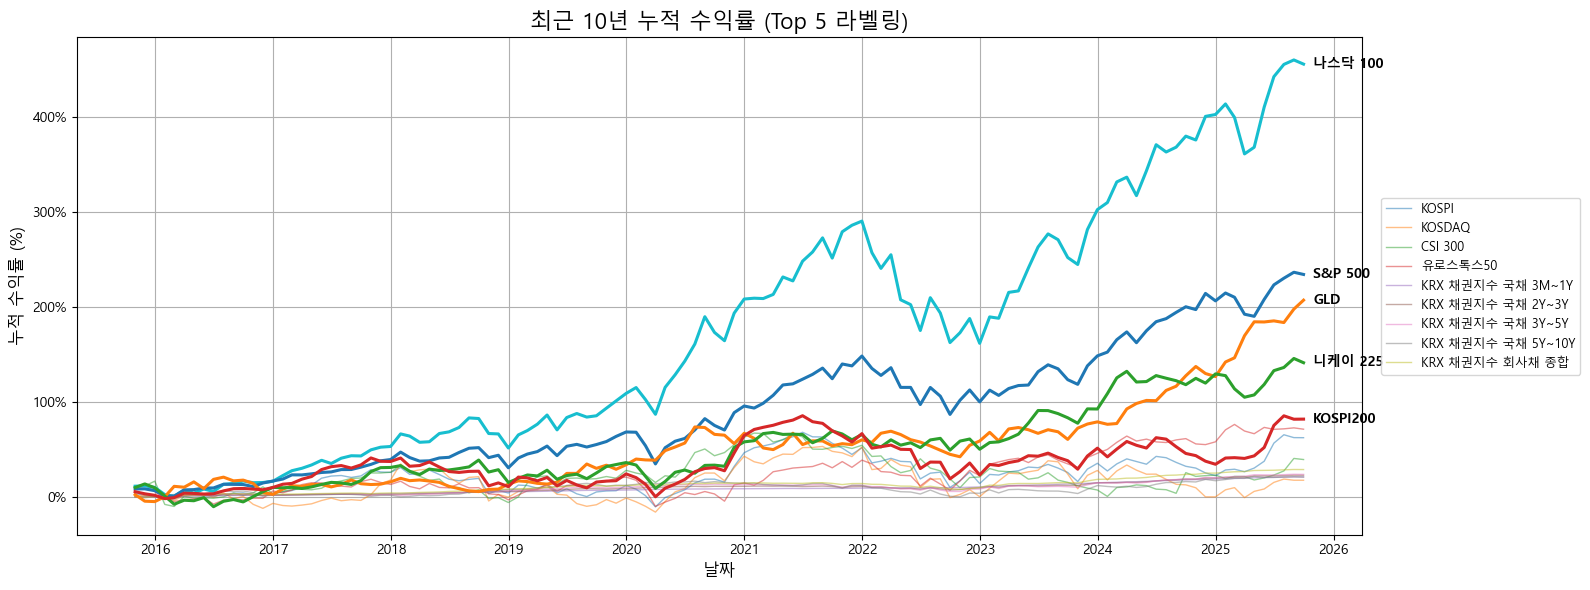

In [6]:
plt.figure(figsize=(16, 6))   # 가로=16, 세로=6 인치

# 마지막 시점 기준 누적 수익률 상위 5개 자산
last_returns = df_cum_return.iloc[-1]
top_assets = last_returns.sort_values(ascending=False).head(5).index
other_assets = [col for col in df_cum_return.columns if col not in top_assets]

# 나머지 자산들 (범례 사용)
for column in other_assets:
    plt.plot(df_cum_return.index, df_cum_return[column], label=column, linewidth=1, alpha=0.5)

# 상위 5개 자산 (직접 라벨링)
for column in top_assets:
    plt.plot(df_cum_return.index, df_cum_return[column], linewidth=2.2)
    last_date = df_cum_return.index[-1]
    last_value = df_cum_return[column].iloc[-1]
    plt.text(last_date + pd.DateOffset(months=1),
             last_value,
             column,
             fontsize=10,
             va='center',
             fontweight='bold')




# y축 퍼센트 형식
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# 그래프 설정
plt.title("최근 10년 누적 수익률 (Top 5 라벨링)", fontsize=16)
plt.xlabel("날짜", fontsize=12)
plt.ylabel("누적 수익률 (%)", fontsize=12)
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), fontsize=9)  # 범례는 나머지용
plt.tight_layout()

plt.show()

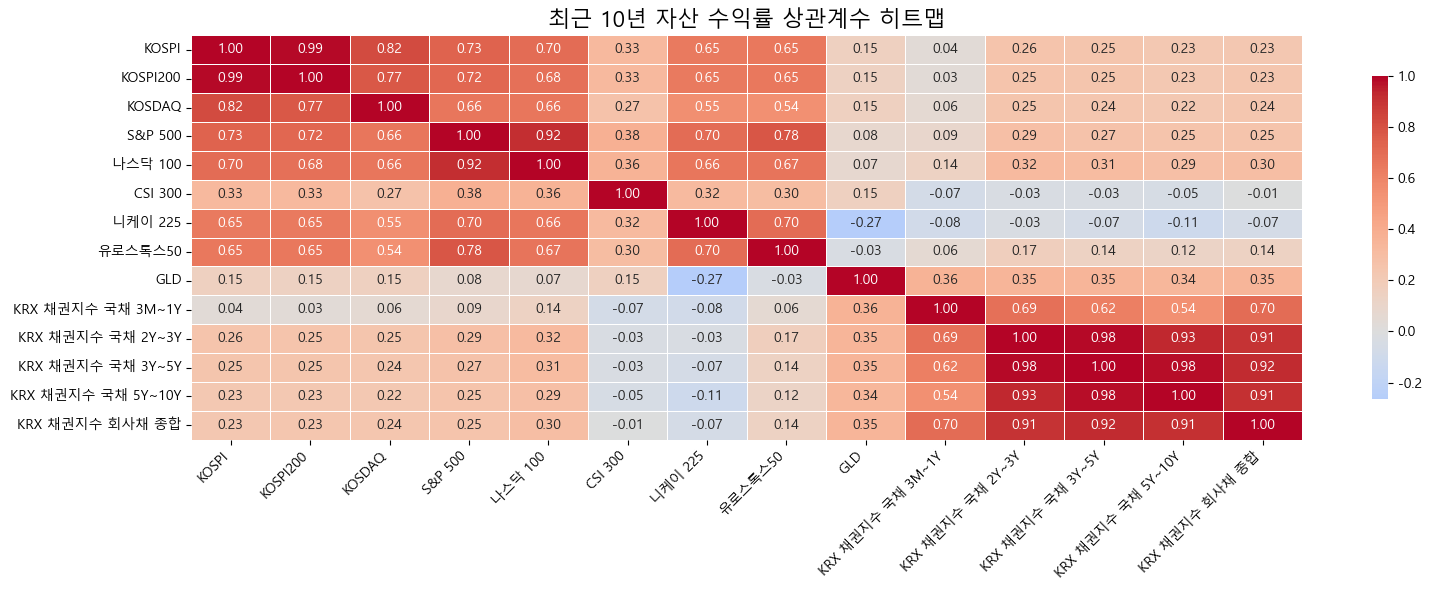

In [7]:
import seaborn as sns

# ① 공분산 행렬
cov_matrix = df_monthly_return.cov()

# ② 상관계수 행렬
corr_matrix = df_monthly_return.corr()

# 히트맵 시각화
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("최근 10년 자산 수익률 상관계수 히트맵", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 2-2. 예/적금/청약통장 자산군

1. 예/적금 상품
- 가장 이율 높은 상품 한 개 추천

2. 청년도약계좌 및 청약통장(청년 주택드림 등)은 필수로 가입하는 게 권장되니, 일단 의무로 포트폴리오에 편입

3. 청년도약계좌
- 연봉별로 가장 먼저 지원금이 다름
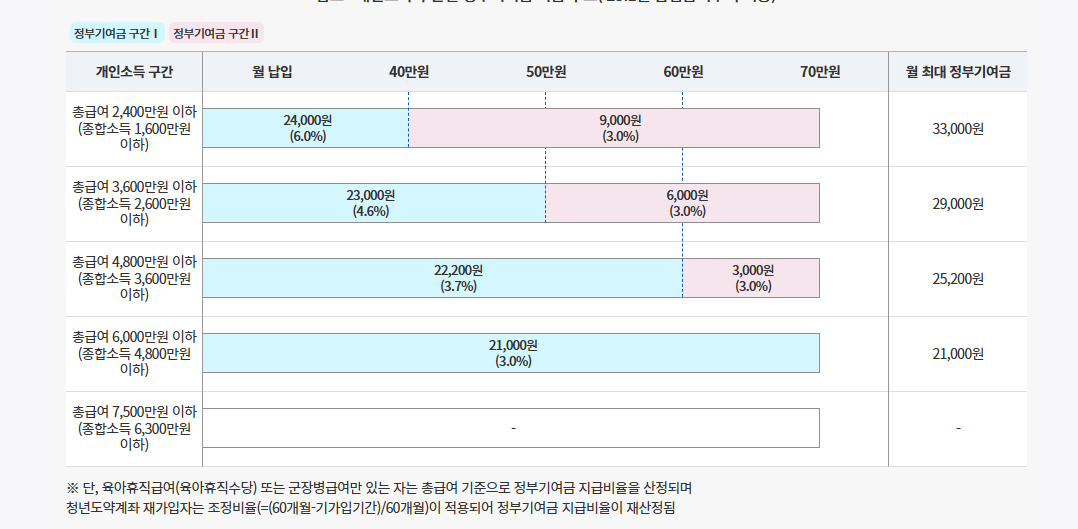
4. 청약통장
- 그냥 월별 10만원



#### 2-2-1. 청년도약계좌

In [8]:
import pandas as pd
import numpy as np
from typing import Dict, Tuple

class YouthLeapAccount:
    """
    청년도약계좌의 소득구간 및 월납입액에 따른
    정부기여금 및 총기대수익률을 계산하고 테이블을 생성하는 클래스입니다.
    (최종 수정: '매칭율+상한' 구조 및 1천원 단위 납입을 정확히 반영)
    """
    def __init__(self, household_file_path: str):
        self.household_file_path = household_file_path
        self.annual_salary = self._get_annual_salary()
        self.income_band_key = self._get_income_band_key()
        print(f"✅ 고객님의 추정 연소득: {self.annual_salary:,.0f}원")
        print(f"✅ 적용 소득구간: 총급여 {self.income_band_key:,}만원 이하")

    def _get_annual_salary(self) -> float:
        try:
            df = pd.read_excel(
                self.household_file_path, sheet_name='뱅샐현황',
                usecols="E:J", engine='openpyxl'
            )
            monthly_salary = df.iloc[17].mean()
            return monthly_salary * 12
        except Exception as e:
            print(f"⚠️ 가계부 파일에서 소득 정보를 읽는 중 오류 발생: {e}")
            return 0.0

    def _get_income_band_key(self) -> int:
        salary_in_won = self.annual_salary / 10000
        income_bands = [2400, 3600, 4800, 6000, 7500]
        for band_max in sorted(income_bands):
            if salary_in_won <= band_max:
                return band_max
        return max(income_bands)

    def _calculate_gov_contribution(self, deposit: int, band_key: int) -> int:
        """
        특정 소득구간과 납입액에 대한 정부기여금을 '매칭율+상한' 방식으로 계산합니다.
        """
        # 1천원 단위 납입액 유효성 검사
        if not (1_000 <= deposit <= 700_000 and deposit % 1_000 == 0):
            if deposit != 0: # 0원은 허용
                print(f"⚠️ {deposit:,}원은 유효하지 않은 납입액입니다. 1천원 이상, 70만원 이하 1천원 단위로 입력해주세요.")
            return 0

        # 소득 구간별 매칭율(rate) 및 기여금 상한(cap)이 적용되는 납입액 구간(breakpoint) 정의
        # breakpoint: 이 금액까지 납입해야 Rate 1의 최대 기여금을 받음
        params_table = {
            2400: {'breakpoint': 400_000, 'rate1': 0.060, 'rate2': 0.030},
            3600: {'breakpoint': 500_000, 'rate1': 0.046, 'rate2': 0.030},
            4800: {'breakpoint': 600_000, 'rate1': 0.037, 'rate2': 0.030},
        }

        total_contribution = 0
        
        if band_key in params_table:
            params = params_table[band_key]
            breakpoint = params['breakpoint']
            rate1 = params['rate1']
            rate2 = params['rate2']
            
            if deposit <= breakpoint:
                # breakpoint까지는 Rate 1만 적용
                total_contribution = deposit * rate1
            else:
                # breakpoint를 초과하면, breakpoint까지는 Rate 1의 최대치,
                # 초과분에 대해서는 Rate 2를 적용
                base_contribution = breakpoint * rate1
                over_contribution = (deposit - breakpoint) * rate2
                total_contribution = base_contribution + over_contribution
        
        elif band_key == 6000:
            # 6000만원 이하 구간은 단일 매칭율(3.0%)에 최대 기여금 한도(21,000원)만 적용
            contribution = deposit * 0.03
            total_contribution = min(contribution, 21_000)

        # 7500만원 이하 구간은 기여금이 없으므로 초기값 0이 반환됨

        return int(round(total_contribution))

    def calculate_contribution(self, monthly_deposit: int) -> int:
        """'현재 사용자'의 소득구간에 맞는 정부기여금을 계산합니다."""
        return self._calculate_gov_contribution(monthly_deposit, self.income_band_key)

    def generate_rate_table(
        self,
        deposits: Tuple[int, ...] = (400_000, 500_000, 600_000, 700_000),
        base_rate_pct: float = 4.5
    ) -> pd.DataFrame:
        """모든 소득구간에 대해 월납입액별 정부기여금과 총기대수익률 테이블을 생성합니다."""
        rows = []
        income_bands = [2400, 3600, 4800, 6000, 7500]
        
        for band_key in income_bands:
            row_label = f"~{band_key:,}만원"
            row_data = {"소득구간": row_label}

            for d in deposits:
                gov = self._calculate_gov_contribution(d, band_key)
                add_yield_pct = (gov / d * 100) if d > 0 else 0
                total_yield_pct = base_rate_pct + add_yield_pct

                col_label = f"{d // 10000}만"
                row_data[(col_label, "정부기여금(원)")] = gov
                row_data[(col_label, "추가수익률(%)")] = add_yield_pct
                row_data[(col_label, "총기대수익률(%)")] = total_yield_pct
            rows.append(row_data)

        df = pd.DataFrame(rows).set_index("소득구간")
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        return df.round(2)

#### 2-2-2. 청약통장

In [9]:
import pandas as pd

class HousingSubscriptionAccount:
    """
    청년 주택드림 청약통장 정보를 관리하고 미래가치를 계산하는 클래스입니다.
    """
    def __init__(self, name: str, interest_rate: float, monthly_deposit: int):
        """
        클래스 초기화 시 상품의 기본 정보를 설정합니다.
        
        :param name: 상품명 (e.g., "청년 주택드림 청약통장")
        :param interest_rate: 연 이율 (e.g., 3.1%는 0.031로 입력)
        :param monthly_deposit: 월 납입액
        """
        self.name = name
        self.interest_rate = interest_rate
        self.monthly_deposit = monthly_deposit
        print(f"✅ '{self.name}' 자산이 생성되었습니다 (연 {self.interest_rate*100}% 금리, 월 {self.monthly_deposit:,}원 납입).")

    def get_asset_details(self) -> dict:
        """
        포트폴리오에 추가하기 용이하도록 자산 정보를 딕셔너리 형태로 반환합니다.
        """
        return {
            "자산명": self.name,
            "유형": "저축성(청약)",
            "기대수익률(%)": self.interest_rate * 100,
            "월납입액(원)": self.monthly_deposit
        }

    def calculate_future_value(self, years: int) -> float:
        """
        매월 일정 금액을 납입했을 때, 특정 년도 후의 미래가치(원리금 합계)를 계산합니다.
        (월 복리 기준)
        """
        r = self.interest_rate / 12  # 월 이율
        n = years * 12               # 총 납입 개월 수
        
        # 정기적금 미래가치(FV) 공식 적용
        future_value = self.monthly_deposit * ((((1 + r) ** n) - 1) / r) * (1 + r)
        
        return future_value
    

    # 1. 청년 주택드림 청약통장 자산 생성
# 연 3.1% 금리, 월 10만원 납입 조건
cheongyak = HousingSubscriptionAccount(
    name="청년 주택드림 청약통장",
    interest_rate=0.031,
    monthly_deposit=100000
)

# 2. 자산의 기본 정보 확인
asset_info = cheongyak.get_asset_details()
print("\n--- 포트폴리오 편입용 자산 정보 ---")
print(asset_info)

# 3. 5년 후 만기 시 예상 원리금(미래가치) 계산
fv_5_years = cheongyak.calculate_future_value(years=5)
print(f"\n▶ 5년 납입 시 예상 만기금액: 약 {fv_5_years:,.0f} 원")

# 10년 후 예상 원리금(미래가치) 계산
fv_10_years = cheongyak.calculate_future_value(years=10)
print(f"▶ 10년 납입 시 예상 만기금액: 약 {fv_10_years:,.0f} 원")

✅ '청년 주택드림 청약통장' 자산이 생성되었습니다 (연 3.1% 금리, 월 100,000원 납입).

--- 포트폴리오 편입용 자산 정보 ---
{'자산명': '청년 주택드림 청약통장', '유형': '저축성(청약)', '기대수익률(%)': 3.1, '월납입액(원)': 100000}

▶ 5년 납입 시 예상 만기금액: 약 6,497,695 원
▶ 10년 납입 시 예상 만기금액: 약 14,083,264 원


#### 2-2-3. 맞춤 예적금 상품 추천

## 3. 은퇴설계

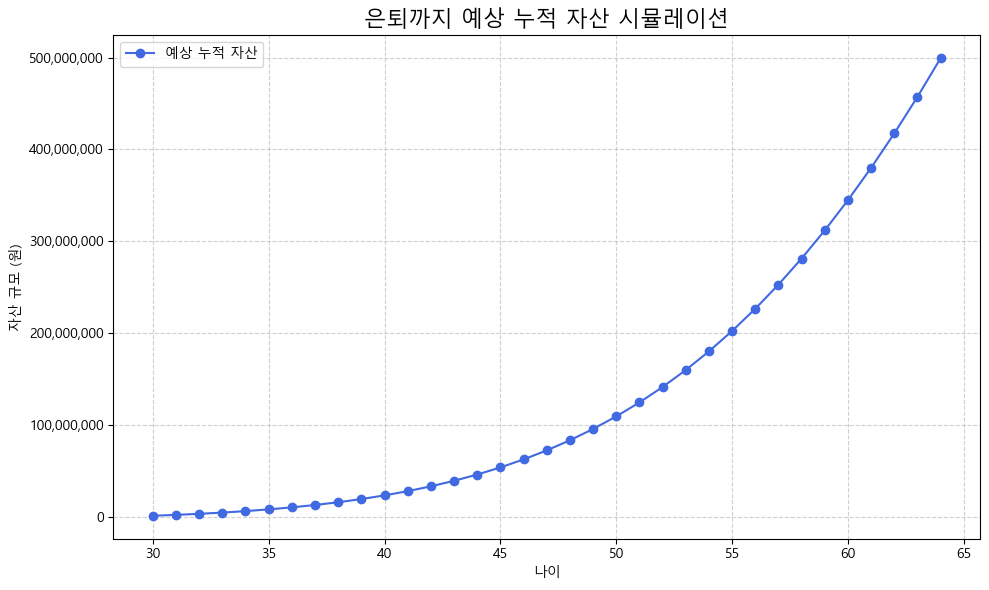


--- 📝 첫 해 기준, 자산별 월 투자금 배분 ---


자산명,비중(%),월 투자금(원)
나스닥 100,17.50%,"10,790원"
GLD,70.78%,"43,633원"
KRX 채권지수 회사채 종합,11.71%,"7,221원"
종합,99.99%,"61,645원"


In [10]:
import pandas as pd
import numpy as np
import cvxpy as cp
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- 기존 코드와 동일한 부분 (설정 및 변수 추출) ---

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 파일 경로 (사용자 환경에 맞게 수정 필요)
# 이 코드를 실행하기 전에 'df_monthly_return' 데이터프레임이 미리 정의되어 있어야 합니다.
retirement_file = "손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx"

# 2. 변수 추출
core_df = pd.read_excel(retirement_file, sheet_name='핵심 정보(가정,변수)', header=None)
core_df.columns = ['A', '항목', '값', '비고', 'E']
core_df = core_df[['항목', '값']].dropna()
core_df['값'] = pd.to_numeric(core_df['값'], errors='coerce')
variables = dict(core_df.set_index('항목')['값'])

current_age = int(variables['현재 나이'])
retire_age = int(variables['은퇴 나이'])
retire_years = int(variables['은퇴기간'])
inflation = float(variables['물가상승률(%)'])
gov_pension_monthly = float(variables['공무원연금(월) (현재시점)'])
target_monthly_spending = float(variables['최종 조정 목표 월별 소비금액'])
years_until_retirement = retire_age - current_age

# 3. 투자 성향
survey_df = pd.read_excel(retirement_file, sheet_name='r설문지 응답', header=None)
text_cells = survey_df.astype(str).values.flatten().tolist()
risk_types = ['안정형', '안정추구형', '위험중립형', '적극투자형', '공격투자형']
profile = next((r for cell in text_cells for r in risk_types if r in cell), '위험중립형')
vol_limit_map = {'안정형': 0.05, '안정추구형': 0.07, '위험중립형': 0.10, '적극투자형': 0.13, '공격투자형': 0.16}
target_vol = vol_limit_map[profile]

# 4. 자산 데이터 준비 (df_monthly_return이 정의되어 있다고 가정)
returns = df_monthly_return.dropna()
asset_names = returns.columns
n_assets = len(asset_names)
is_stock = np.array([0 if '채권' in name or '현금' in name else 1 for name in asset_names])

# --- ★★★ 핵심 수정 사항: TDF 로직 수정 ★★★ ---
def tdf_max_stock_ratio(current_year_index, total_years, max_ratio=0.9, min_ratio=0.3):
    """
    올바르게 수정된 TDF 글라이드패스 함수.
    '남은 기간'을 기준으로 주식 비중을 계산합니다.
    """
    # 기간 경과에 따라 주식 비중이 선형으로 감소
    glide_ratio = ((total_years-1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))

# 6. 기대수익률 및 공분산 계산 (EWMA 방식 적용)
span = 60
mu = returns.ewm(span=span).mean().iloc[-1].values * 12
cov = returns.ewm(span=span).cov().iloc[-n_assets:].values * 12

# 7. 연령별 기대수익률 계산
yearly_expected_return = []
yearly_opt_weights = []

# 'i'를 사용하여 투자 진행 연차를 명확히 함
for i in range(years_until_retirement):
    # 수정된 함수 호출
    stock_limit = tdf_max_stock_ratio(i, years_until_retirement)
    w = cp.Variable(n_assets)
    constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov) <= target_vol**2, is_stock @ w <= stock_limit]
    prob = cp.Problem(cp.Maximize(mu @ w), constraints)
    prob.solve()
    
    if w.value is not None:
        yearly_expected_return.append(mu @ w.value)
        yearly_opt_weights.append(w.value)
    else:
        # 최적화 실패 시 안전자산 100%로 설정
        safe_asset_idx = [idx for idx, label in enumerate(classify(name) for name in asset_names) if label == '안전자산'][0]
        w_safe = np.zeros(n_assets)
        w_safe[safe_asset_idx] = 1.0
        yearly_expected_return.append(mu @ w_safe)
        yearly_opt_weights.append(w_safe)

# 8. 필요 은퇴자금 계산
fv_spending = target_monthly_spending * (1 + inflation) ** years_until_retirement
fv_gov_pension = gov_pension_monthly * (1 + inflation) ** years_until_retirement
monthly_gap = max(fv_spending - fv_gov_pension, 0)
total_required = monthly_gap * 12 * retire_years

# 9. 이진 탐색으로 월 투자금 계산
def simulate_retirement_fund(monthly_invest, rate_list):
    fund = 0
    for r in rate_list:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_invest
    return fund

low, high = 1, 10_000_000
while high - low > 1000:
    mid = (low + high) // 2
    if simulate_retirement_fund(mid, yearly_expected_return) > total_required:
        high = mid
    else:
        low = mid
monthly_invest_final = high

# 10. 자산 누적 시뮬레이션 및 시각화
def simulate_asset_path(monthly_invest, rate_list):
    fund = 0
    path = []
    for r in rate_list:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_invest
        path.append(fund)
    return path

asset_path = simulate_asset_path(monthly_invest_final, yearly_expected_return)
ages = list(range(current_age, retire_age))

plt.figure(figsize=(10, 6))
plt.plot(ages, asset_path, label="예상 누적 자산", marker='o', color='royalblue')
plt.xlabel("나이")
plt.ylabel("자산 규모 (원)")
plt.title("은퇴까지 예상 누적 자산 시뮬레이션", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

# 11. 최종 자산 배분 및 월 투자금 요약
final_weights = yearly_opt_weights[0]
amounts_by_asset = final_weights * monthly_invest_final
asset_result = pd.DataFrame({
    '자산명': asset_names,
    '비중(%)': final_weights * 100,
    '월 투자금(원)': amounts_by_asset
})
asset_result = asset_result[asset_result['비중(%)'] > 0.1].round(2)

total_row = pd.DataFrame({
    '자산명': ['종합'],
    '비중(%)': [asset_result['비중(%)'].sum()],
    '월 투자금(원)': [asset_result['월 투자금(원)'].sum()]
})
asset_result = pd.concat([asset_result, total_row], ignore_index=True)

print("\n--- 📝 첫 해 기준, 자산별 월 투자금 배분 ---")
display(asset_result.style.format({'비중(%)': '{:,.2f}%', '월 투자금(원)': '{:,.0f}원'}).hide(axis="index"))



In [11]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- 1. 이전 셀에서 계산된 변수들이 필요합니다 ---
# 이 코드를 실행하기 전에 mu, cov, target_vol, years_until_retirement, 
# ages, asset_names, tdf_max_stock_ratio 함수 등이 정의되어 있어야 합니다.

# --- 2. 연령별 기대수익률 + 포트폴리오 기록용 테이블 생성 (수정된 로직) ---
yearly_stock_limit = []
yearly_target_vol = []
yearly_portfolio_vol = []
yearly_expected_return = []
yearly_opt_weights = []

# 'i'를 사용하여 투자 진행 연차를 명확히 함
for i in range(years_until_retirement):
    # ★★★ 올바른 함수 호출 방식으로 수정 ★★★
    stock_limit = tdf_max_stock_ratio(i, years_until_retirement)
    
    w = cp.Variable(n_assets)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        cp.quad_form(w, cov) <= target_vol**2,
        is_stock @ w <= stock_limit
    ]
    prob = cp.Problem(cp.Maximize(mu @ w), constraints)
    prob.solve()

    if w.value is not None:
        w_opt = w.value
        r = mu @ w_opt
        vol = np.sqrt(w_opt @ cov @ w_opt)
    else:
        # 최적화 실패 시 안전자산 100%로 설정
        safe_asset_idx = [idx for idx, label in enumerate(classify(name) for name in asset_names) if label == '안전자산'][0]
        w_opt = np.zeros(n_assets)
        w_opt[safe_asset_idx] = 1.0
        r = mu @ w_opt
        vol = np.sqrt(w_opt @ cov @ w_opt)

    yearly_stock_limit.append(stock_limit)
    yearly_target_vol.append(target_vol)
    yearly_expected_return.append(r)
    yearly_portfolio_vol.append(vol)
    yearly_opt_weights.append(w_opt)

# --- 3. 기대수익률 테이블 만들기 ---
table_df = pd.DataFrame({
    '나이': ages,
    '주식 상한(%)': np.round(np.array(yearly_stock_limit) * 100, 1),
    '변동성 제한(%)': np.round(np.array(yearly_target_vol) * 100, 1),
    '기대수익률(%)': np.round(np.array(yearly_expected_return) * 100, 2),
    '포트폴리오 변동성(%)': np.round(np.array(yearly_portfolio_vol) * 100, 2)
})

print("\n--- 📋 연령별 투자 전략 요약 테이블 ---")
# display 함수는 Jupyter Notebook 환경에서 표를 예쁘게 보여줍니다.
display(table_df.style.format("{:,.2f}"))




--- 📋 연령별 투자 전략 요약 테이블 ---


,나이,주식 상한(%),변동성 제한(%),기대수익률(%),포트폴리오 변동성(%)
0,30.00,88.30,10.00,18.34,10.00
1,31.00,86.60,10.00,18.09,10.00
2,32.00,84.90,10.00,17.83,10.00
3,33.00,83.10,10.00,17.57,10.00
4,34.00,81.40,10.00,17.31,10.00
5,35.00,79.70,10.00,17.05,10.00
6,36.00,78.00,10.00,16.79,10.00
7,37.00,76.30,10.00,16.53,10.00
8,38.00,74.60,10.00,16.26,10.00
9,39.00,72.90,10.00,15.99,9.93



--- 📋 연령별 상세 자산 배분 계획표 (%) ---


,나스닥 100,GLD,KRX 채권지수 회사채 종합
30,17.5%,70.8%,11.7%
31,14.9%,71.7%,13.4%
32,12.5%,72.4%,15.1%
33,10.3%,72.8%,16.9%
34,8.3%,73.2%,18.6%
35,6.3%,73.4%,20.3%
36,4.5%,73.5%,22.0%
37,2.8%,73.5%,23.7%
38,1.1%,73.5%,25.4%
39,0.0%,72.9%,27.1%


c:\Users\tjw71\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


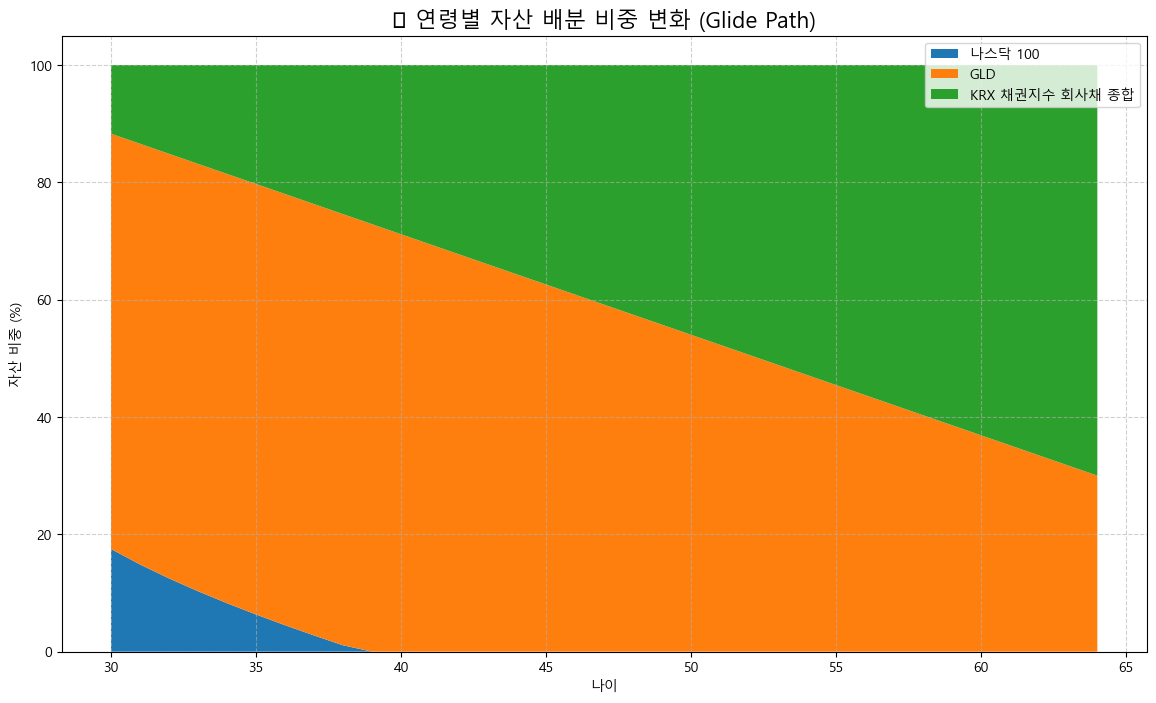

In [12]:
# --- 2. 연도별 포트폴리오 상세 계획표 생성 ---

# 연령별 최적 비중을 DataFrame으로 변환
weights_df = pd.DataFrame(yearly_opt_weights, index=ages, columns=asset_names)

# 비중이 0.1% 이상이었던 자산만 필터링하여 보기 쉽게 만듭니다.
weights_df = weights_df.loc[:, (weights_df > 0.001).any(axis=0)]
weights_df *= 100 # 백분율로 변환

print("\n--- 📋 연령별 상세 자산 배분 계획표 (%) ---")
display(weights_df.style.format("{:,.1f}%"))


# --- 3. 스택형 영역 차트로 시각화 ---

plt.figure(figsize=(14, 8))
plt.stackplot(weights_df.index, weights_df.T, labels=weights_df.columns)
plt.legend(loc='upper right')
plt.title('📈 연령별 자산 배분 비중 변화 (Glide Path)', fontsize=16)
plt.xlabel('나이')
plt.ylabel('자산 비중 (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## 4. 종합설계

### 4-1. 재무목표 도출

In [13]:
# %%
# 은퇴 목표 정보 구성 (GPT용)
retirement_goal_description = f"""
- 은퇴 목표 시점: 만 {retire_age}세
- 은퇴 기간: {retire_years}년
- 목표 생활비: 월 {int(target_monthly_spending):,}원
- 예상 총 필요 은퇴자금: 약 {int(total_required):,}원
- 예상 연금 수령: 월 {int(gov_pension_monthly):,}원
"""
print(retirement_goal_description)



- 은퇴 목표 시점: 만 65세
- 은퇴 기간: 35년
- 목표 생활비: 월 2,500,000원
- 예상 총 필요 은퇴자금: 약 496,529,103원
- 예상 연금 수령: 월 2,000,000원



In [14]:
import openai
import ast
import re
import json
import os

# ==============================================================================
# ⭐️ 1. AI 응답 검증 및 정규화 함수 (수정된 버전)
# ==============================================================================
def validate_and_normalize_goals(parsed_list, source_ai_version="1차"):
    """
    AI가 생성한 목표 리스트를 검증하고, 백테스팅에 사용할 수 있는
    표준 형식({'name', 'years', 'target', 'priority', 'necessity'})으로 변환합니다.
    """
    cleaned_goal_list = []
    
    def extract_years(time_frame_value):
        if isinstance(time_frame_value, (int, float)): return int(time_frame_value)
        if isinstance(time_frame_value, str):
            numbers = re.findall(r'\d+', time_frame_value)
            return int(numbers[0]) if numbers else None
        return None

    for item in parsed_list:
        name = item.get('name') or item.get('목표명')
        target = item.get('target') or item.get('goal_amount')
        time_value = item.get('time_frame') or item.get('years')
        years = extract_years(time_value)
        
        # ⭐️ 중요: 우선순위와 필수성 정보를 반드시 가져오도록 수정
        priority = item.get('priority')
        necessity = item.get('necessity')

        # 1차 AI 응답에서는 모든 정보가 필수입니다.
        if not all([name, target, years, priority, necessity]):
            print(f"⚠️ 경고 ({source_ai_version} AI): '{name or '이름 없는'}' 목표에서 필수 정보(이름, 금액, 기간, 우선순위, 필수성)가 누락/유효하지 않아 제외합니다.")
            continue
            
        cleaned_goal_list.append({
            'name': name, 
            'years': int(years), 
            'target': int(target), 
            'is_short_term': int(years) <= 1,
            'priority': priority, 
            'necessity': necessity
        })
    return cleaned_goal_list

In [15]:
GOAL_LIST_SCHEMA = {
    "name": "goal_list_v1",
    "schema": {
        "type": "object",
        "additionalProperties": False,
        "properties": {
            "goals": {
                "type": "array",
                "items": {
                    "type": "object",
                    "additionalProperties": False,
                    "properties": {
                        "name":       {"type": "string", "description": "목표 이름"},
                        "years":      {"type": "integer", "minimum": 1, "maximum": 50, "description": "달성까지 남은 연수"},
                        "target":     {"type": "integer", "minimum": 0, "description": "목표 금액(원)"},
                        "priority":   {"type": "integer", "minimum": 1, "maximum": 5, "description": "우선순위(1=최상)"},
                        "necessity":  {"type": "string", "enum": ["필수","선택"], "description": "필수 여부"}
                    },
                    "required": ["name","years","target","priority","necessity"]
                }
            }
        },
        "required": ["goals"]
    },
    "strict": True
}

# ==============================================================================
# 2. 메인 실행 로직 (기존과 동일하되, LLM 호출/파싱만 교체)
# ==============================================================================
cache_file_path = "financial_goals_cache.json"
goal_list = []

if os.path.exists(cache_file_path):
    print(f"✅ 캐시 파일({cache_file_path})을 발견했습니다. API 호출 없이 데이터를 불러옵니다.")
    with open(cache_file_path, 'r', encoding='utf-8') as f:
        goal_list = json.load(f)
else:
    print(f"ℹ️ 캐시 파일이 없습니다. OpenAI API를 호출하여 재무 목표를 생성합니다.")
    
    savings_capacity = avg_cash_surplus  # 기존 변수 그대로 사용

    # ✅ 스키마 필드명에 맞춘 지시 (중괄호 이스케이프 주의!)
    system_prompt = f"""
    당신은 FPSB 공인 CFP 자격을 보유한 재무설계 전문가이며, 고객 재무목표 설계 알고리즘을 위한 전문가 자문 역할을 수행합니다.

    **[최상위 제약]**
    - 모든 재무 목표를 달성하기 위한 월 필요 저축액의 총합은 고객의 월 저축/투자 가능 금액인 {savings_capacity:,.0f}원을 절대 초과하지 않아야 합니다.

    **[출력 형식(중요)]**
    - 아래 스키마에 '정확히' 맞춰 **객체**를 출력하세요. 추가 키 금지.
    - 최상위는 {{\"goals\": [...]}} 형태이며, goals는 다음 항목들의 배열입니다:
    {{name:str, years:int, target:int, priority:int(1~5), necessity:\"필수\"|\"선택\"}}

    **[세부 수행 지침]**
    1. 고객의 재무상태, 생애주기, 소득수준, 소비/부채 구조, 투자성향 및 재무지식 수준을 종합 분석.
    2. CFP 국제 기준 및 한국형 실무 원칙에 따라 필요한 재무목표들을 도출.
    3. 각 목표는 다음 필드를 사용:
    - name: 목표 이름
    - years: 목표 달성까지 남은 연수(정수, 년 단위)
    - target: 목표 금액(원, 정수)
    - priority: 1~5 (1이 최상)
    - necessity: "필수" 또는 "권장"
    4. 고객이 직접 제시한 목표가 있어도, **월 {savings_capacity:,.0f}원** 한도 내 달성이 가능하도록 금액/기간을 조정(근거는 내부적으로 고려하되 출력에는 포함하지 않음).
    5. 1/3/5/10년 등 일반 저축 목표는 고객의 소득/지출 구조를 반영한 현실적 권고 수준으로 설정.
    6. 재무건전성/유동성/생애주기를 반영해 합리적 우선순위 부여.
    7. 아래 '은퇴 관련 목표 정보'는 내용 수정 없이 **중요도 판단만 반영**.

    **[응답 규칙]**
    - 설명 문장, 마크다운, 코드블록, 주석 없이 **JSON 객체만** 출력.
    - 최상위에 "goals" 배열을 포함할 것.
    - 스키마에 정의되지 않은 키는 절대 포함하지 말 것.
    """


    user_prompt = f"""
    [고객 프로필 정보]\n{client_profile}\n
    [설문 응답 정보]\n{survey_answers}\n
    [은퇴 관련 목표 정보]\n{retirement_goal_description}
    """

    try:
        # ✅ 키 하드코딩 금지: 환경변수 사용 권장 (예: OPENAI_API_KEY)
        client = openai.OpenAI()  

        # ✅ 구조화 출력: 스키마 강제
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0.5,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_schema", "json_schema": GOAL_LIST_SCHEMA}
        )

        raw_json = response.choices[0].message.content
        parsed = json.loads(raw_json)
        goal_list = parsed["goals"]  # ← 래퍼에서 goals만 꺼냄


        # (선택) 후속 검증/보정 훅: 기존 함수를 슬림화해서 유지하고 싶다면 아래 라인 주석 해제
        # goal_list = validate_and_normalize_goals(goal_list, source_ai_version="구조화")

        # 캐시 저장
        if goal_list:
            with open(cache_file_path, 'w', encoding='utf-8') as f:
                json.dump(goal_list, f, ensure_ascii=False, indent=4)
            print(f"\n✅ 구조화 응답을 '{cache_file_path}' 파일에 저장했습니다.")
        else:
            print("\n⚠️ 유효한 재무 목표가 비어 있습니다.")

    except Exception as e:
        print(f"\n⚠️ API 호출 또는 파싱 중 오류가 발생했습니다: {e}")

if goal_list:
    print("\n✅ 최종 생성된 재무 목표 'goal_list':")
    print(goal_list)
else:
    print("\n⚠️ 'goal_list'가 생성되지 않았습니다. API 응답 또는 캐시 파일을 확인해주세요.")


✅ 캐시 파일(financial_goals_cache.json)을 발견했습니다. API 호출 없이 데이터를 불러옵니다.

✅ 최종 생성된 재무 목표 'goal_list':
[{'name': '단기 저축 목표', 'years': 5, 'target': 100000000, 'priority': 2, 'necessity': '필수'}, {'name': '은퇴 자금 마련', 'years': 35, 'target': 496529103, 'priority': 1, 'necessity': '필수'}, {'name': '여행 자금', 'years': 1, 'target': 20000000, 'priority': 3, 'necessity': '선택'}, {'name': '자녀 교육 자금', 'years': 10, 'target': 300000000, 'priority': 4, 'necessity': '선택'}, {'name': '부동산 투자 자금', 'years': 5, 'target': 200000000, 'priority': 5, 'necessity': '선택'}]


In [16]:
import pandas as pd
import numpy as np

# 0) goal_list를 DataFrame으로 통일
if isinstance(goal_list, pd.DataFrame):
    df = goal_list.copy()
elif isinstance(goal_list, list):
    df = pd.DataFrame(goal_list)
else:
    raise TypeError("goal_list는 list 또는 pandas.DataFrame이어야 합니다.")

# 1) 컬럼 타입/결측 방어
df["necessity"] = df.get("necessity", "선택").fillna("선택")
df["priority"]  = pd.to_numeric(df.get("priority", 99), errors="coerce").fillna(99).astype(int)
df["years"]     = pd.to_numeric(df.get("years", 0), errors="coerce").fillna(0).astype(int)

# 2) 기간 구간 컬럼
def categorize_years(years: int) -> str:
    if years <= 3:
        return "단기"
    elif years <= 10:
        return "중기"
    else:
        return "장기"

df["기간구분"] = df["years"].apply(categorize_years)

# 3) 필수→선택 정렬을 위한 매핑
necessity_order = {"필수": 0, "선택": 1}
df["necessity_order"] = df["necessity"].map(necessity_order).fillna(1).astype(int)

# 4) 정렬: 필수→선택, priority 오름차순
goal_list_sorted = (
    df.sort_values(by=["necessity_order", "priority"], ascending=[True, True])
      .drop(columns=["necessity_order"])
      .reset_index(drop=True)
)

display(goal_list_sorted)


,name,years,target,priority,necessity,기간구분
0,은퇴 자금 마련,35,496529103,1,필수,장기
1,단기 저축 목표,5,100000000,2,필수,중기
2,여행 자금,1,20000000,3,선택,단기
3,자녀 교육 자금,10,300000000,4,선택,중기
4,부동산 투자 자금,5,200000000,5,선택,중기


In [17]:
import pandas as pd
import re

# ==============================================================================
# [솔루션] Ticker-자산군 맵핑 자동화 로직
# ==============================================================================

def get_asset_class_for_ticker(ticker_name: str) -> str:
    """
    종목명(ticker_name)에 포함된 키워드를 분석하여 자산군(asset_class)을 추론합니다.
    (실제 서비스에서는 금융 데이터 API 또는 웹 크롤링을 통해 구현해야 합니다.)

    Args:
        ticker_name (str): 'TIGER 미국나스닥100커버드콜(합성)'과 같은 ETF의 전체 이름.

    Returns:
        str: '미국 커버드콜'과 같이 분류된 자산군 이름.
    """
    ticker_name = ticker_name.upper() # 대소문자 통일

    # 키워드 규칙 (우선순위가 높은 규칙을 먼저 배치)
    if '커버드콜' in ticker_name or 'COVERED CALL' in ticker_name:
        return '미국 커버드콜' # '나스닥100' 키워드보다 우선
    if '나스닥' in ticker_name or 'NASDAQ' in ticker_name:
        return '미국 성장주'
    if 'S&P' in ticker_name:
        return '미국 대표지수'
    if '배당' in ticker_name or '다우존스' in ticker_name or 'DOW JONES' in ticker_name or 'DIVIDEND' in ticker_name:
        # 국내/해외 구분
        if '미국' in ticker_name:
            return '미국 배당주'
        elif 'KOR' in ticker_name or '한국' in ticker_name:
            return '국내 배당주'
        return '기타 배당주'
    if '채권' in ticker_name or 'BOND' in ticker_name:
        if '단기' in ticker_name:
            return '미국 단기채'
        return '기타 채권'
    if re.match(r'^\d{6}$', ticker_name): # 6자리 숫자 코드는 국내 개별 주식으로 간주
        return '국내 개별주'
    
    # 직접 Ticker를 하드코딩해야 하는 경우
    if ticker_name == 'PLUS 고배당주': return '국내 배당주'
    if ticker_name == 'SCHD': return '미국 배당주'
    if ticker_name == 'SPHD': return '미국 배당주'
    if ticker_name == 'JEPQ': return '미국 커버드콜'
    if ticker_name == 'JEPI': return '미국 커버드콜'

    return '기타'

def build_ticker_map_dynamically(tickers: list) -> dict:
    """보유 종목 리스트를 받아 Ticker-자산군 맵을 동적으로 생성합니다."""
    ticker_map = {}
    for ticker in tickers:
        ticker_map[ticker] = get_asset_class_for_ticker(ticker)
    return ticker_map


# ==============================================================================
# 리밸런싱 계획 생성 메인 로직
# ==============================================================================

def parse_holdings_from_profile(client_profile: dict, ticker_map: dict) -> list:
    """client_profile 객체에서 '투자성 자산' 상세 내역을 파싱하여 current_holdings 리스트를 생성합니다."""
    investment_assets = client_profile.get("자산 상세", {}).get("투자성 자산", {})
    
    holdings = []
    for ticker, value in investment_assets.items():
        asset_class = ticker_map.get(ticker, '기타')
        
        if asset_class in ['현금성', '기타'] or value < 100000:
            continue
            
        holdings.append({
            'ticker': ticker,
            'asset_class': asset_class,
            'value': float(value)
        })
    return holdings

def create_rebalancing_plan(
    client_profile: dict,
    final_portfolio_df: pd.DataFrame,
    representative_etfs: dict
):
    """
    client_profile에서 직접 보유 자산을 파싱하여 리밸런싱 계획을 생성합니다.

    Args:
        client_profile (dict): [필수] ipynb Cell 2의 전체 출력 결과.
        final_portfolio_df (pd.DataFrame): [필수] ipynb Cell 14의 출력 결과.
        representative_etfs (dict): [필수] 자산군별 대표 ETF 맵핑.

    Returns:
        pd.DataFrame: 실행 가능한 거래 계획 (Action Plan).
    """
    # --- 0. 맵핑 테이블 동적 생성 ---
    all_tickers = list(client_profile.get("자산 상세", {}).get("투자성 자산", {}).keys())
    ticker_to_asset_class_map = build_ticker_map_dynamically(all_tickers)
    
    # --- 1. AS-IS 포트폴리오 파싱 및 분석 ---
    current_holdings = parse_holdings_from_profile(client_profile, ticker_to_asset_class_map)
    if not current_holdings:
        print("분석할 투자 자산이 없습니다.")
        return pd.DataFrame()

    df_current = pd.DataFrame(current_holdings)
    total_asset_value = df_current['value'].sum()
    df_as_is = df_current.groupby('asset_class')['value'].sum().to_dict()

    # --- 2. TO-BE 포트폴리오 목표 비중 계산 ---
    monthly_investment_grouped = final_portfolio_df.groupby('자산군')['월 투자금'].sum()
    total_monthly_investment = monthly_investment_grouped.sum()
    if total_monthly_investment == 0:
        return pd.DataFrame()
    target_allocation = (monthly_investment_grouped / total_monthly_investment).to_dict()

    # --- 3. Gap 분석 및 Action Plan 생성 ---
    action_list = []
    cash_for_reinvest = 0

    # 3-1. 매도 대상 결정: 대표 ETF로 교체
    for holding in current_holdings:
        ticker, asset_class, value = holding['ticker'], holding['asset_class'], holding['value']
        rep_ticker = representative_etfs.get(asset_class)
        
        if rep_ticker and ticker != rep_ticker:
            action_list.append({'action': 'SELL', 'ticker': ticker, 'value': value, 'reason': f'대표 ETF({rep_ticker})로 교체'})
            cash_for_reinvest += value
            # AS-IS 자산 현황에서 매도분만큼 차감
            if asset_class in df_as_is:
                df_as_is[asset_class] -= value

    # 3-2. 매도 대상 결정: 비중 조절
    for asset_class, current_value in df_as_is.items():
        target_value = total_asset_value * target_allocation.get(asset_class, 0)
        delta = current_value - target_value
        
        if delta > 0:
            rep_ticker = representative_etfs.get(asset_class)
            action_list.append({'action': 'SELL', 'ticker': rep_ticker, 'value': delta, 'reason': '비중 조절'})
            cash_for_reinvest += delta
            df_as_is[asset_class] -= delta # AS-IS 자산 현황 업데이트

    # --- 4. 매수 계획 수립 ---
    for asset_class, target_weight in target_allocation.items():
        target_value = total_asset_value * target_weight
        current_value_after_sell = df_as_is.get(asset_class, 0)
        
        needed_value = target_value - current_value_after_sell
        
        if needed_value > 0:
            rep_ticker = representative_etfs.get(asset_class)
            action_list.append({'action': 'BUY', 'ticker': rep_ticker, 'value': needed_value, 'reason': '비중 확대'})

    return pd.DataFrame(action_list)



### 4-2. 재무목표별 포트폴리오 최적화 및 월별 금액 조정

In [18]:
# --- 수정된 코드 (클래스 기능 활용 - 권장) ---

# YouthLeapAccount 클래스 인스턴스 생성
yla_calculator = YouthLeapAccount(household_file_path='손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm')

# 1. generate_rate_table() 메소드를 호출하여 모든 경우의 수에 대한 수익률표를 한번에 생성
#    기본 금리를 4.5%로 가정하여 전달
rate_table_df = yla_calculator.generate_rate_table(base_rate_pct=4.5)

# 2. 생성된 DataFrame에서 현재 사용자의 소득구간에 해당하는 행만 추출
user_income_band_label = f"~{yla_calculator.income_band_key:,}만원"
user_rates = rate_table_df.loc[user_income_band_label]

print("--- ✅ 청년도약계좌 납입액별 기대수익률 계산 완료 ---")
print(f"고객님의 소득구간({user_income_band_label}) 적용 결과입니다.")

# 3. '총기대수익률(%)' 데이터만 선택하여 출력
#    (결과가 pandas Series 형태이므로 바로 반복문 적용 가능)
for (amount_label, data_type), rate in user_rates.items():
    if data_type == '총기대수익률(%)':
        # amount_label (예: "40만")에서 숫자만 추출하여 원 단위로 변환
        amount_won = int(amount_label.replace('만', '')) * 10000
        # 수익률은 이미 % 단위이므로 100으로 나눠서 비율로 사용
        print(f"월 {amount_won:,}원 납입 시: 연 {rate/100:.2%}")

# 만약 표 전체를 보고 싶다면 아래 코드를 사용하세요.
# print("\n--- 전체 소득구간별 기대수익률표 ---")
# print(rate_table_df

✅ 고객님의 추정 연소득: 43,556,942원
✅ 적용 소득구간: 총급여 4,800만원 이하
--- ✅ 청년도약계좌 납입액별 기대수익률 계산 완료 ---
고객님의 소득구간(~4,800만원) 적용 결과입니다.
월 400,000원 납입 시: 연 8.20%
월 500,000원 납입 시: 연 8.20%
월 600,000원 납입 시: 연 8.20%
월 700,000원 납입 시: 연 8.10%


In [19]:
import pandas as pd
import numpy as np
import cvxpy as cp
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy_financial as npf

# --- 1 ~ 5. 이전 단계 코드 (수정 없음) ---
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
returns = df_monthly_return.dropna()
asset_names = returns.columns.tolist()
n_assets = len(asset_names)
mu = returns.ewm(span=60).mean().iloc[-1].values * 12
cov = returns.ewm(span=60).cov().iloc[-n_assets:].values * 12
is_stock = np.array([0 if '채권' in name or '현금' in name else 1 for name in asset_names])

def tdf_max_stock_ratio(current_year_index, total_years, max_ratio=0.9, min_ratio=0.3):
    glide_ratio = ((total_years - 1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))

if not isinstance(goal_list_sorted, pd.DataFrame):
    goal_list_sorted = pd.DataFrame(goal_list_sorted)

# --- ★★★ 수정된 부분 시작 ★★★ ---

# 6. 월 가용 투자금 재계산 (청약통장 금액을 명시적으로 먼저 차감)
MONTHLY_CHEONGYAK_SAVING = cheongyak.monthly_deposit
available_monthly_investment = avg_cash_surplus # 전체 여윳돈에서 시작
CASH_BUFFER_RATIO = 0.10

# 고정 지출인 청약저축을 먼저 제외
investable_after_cheongyak = available_monthly_investment - MONTHLY_CHEONGYAK_SAVING
# 남은 금액에서 현금성 자산(유동성)을 배분
cash_buffer_amount = investable_after_cheongyak * CASH_BUFFER_RATIO
# 최종적으로 다른 목표들에 최적화할 수 있는 금액
investable_for_goals = investable_after_cheongyak - cash_buffer_amount

print(f"✅ 청약통장 납입액(월 {MONTHLY_CHEONGYAK_SAVING:,.0f}원)을 제외한 월 가용 투자금: {investable_after_cheongyak:,.0f}원")
print(f"✅ 이 중 10%인 {cash_buffer_amount:,.0f}원을 현금성 자산으로 우선 배분합니다.")
print(f"✅ 재무 목표 달성을 위한 월 최적화 가능 투자금: {investable_for_goals:,.0f}원\n")

# --- 청년도약계좌 시나리오 분석 (기존과 동일) ---
yla_scenario_deposits = [400000, 500000, 600000, 700000]
all_scenario_results = []
user_income_band_label = f"~{yla_calculator.income_band_key:,}만원"
user_rates = rate_table_df.loc[user_income_band_label]
for deposit_amount in yla_scenario_deposits:
    deposit_label = f"{deposit_amount // 10000}만"; current_yla_return = user_rates.loc[(deposit_label, '총기대수익률(%)')] / 100
    asset_names_with_yla = asset_names + ['청년도약계좌']; mu_with_yla = np.append(mu, current_yla_return)
    cov_with_yla = np.zeros((n_assets + 1, n_assets + 1)); cov_with_yla[:n_assets, :n_assets] = cov; is_stock_with_yla = np.append(is_stock, 0)
    goal_results_for_scenario = []
    for index, goal in goal_list_sorted.iterrows():
        years, target, name, priority, necessity, 기간구분 = goal[['years', 'target', 'name', 'priority', 'necessity', '기간구분']]
        use_yla = years <= 5
        current_mu, current_cov, current_is_stock, current_n_assets, current_asset_names = (mu_with_yla, cov_with_yla, is_stock_with_yla, n_assets + 1, asset_names_with_yla) if use_yla else (mu, cov, is_stock, n_assets, asset_names)
        yearly_returns, first_year_weights = [], np.zeros(current_n_assets)
        for i in range(years):
            stock_limit = tdf_max_stock_ratio(i, years); w = cp.Variable(current_n_assets)
            constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, current_cov) <= target_vol**2, current_is_stock @ w <= stock_limit]
            prob = cp.Problem(cp.Maximize(current_mu @ w), constraints); prob.solve(solver=cp.SCS)
            if w.value is not None:
                yearly_returns.append(current_mu @ w.value)
                if i == 0: first_year_weights = w.value if w.value is not None else np.zeros(current_n_assets)
            else:
                safe_returns = current_mu[current_is_stock == 0]; yearly_returns.append(np.min(safe_returns) if len(safe_returns) > 0 else 0)
        avg_return = np.mean(yearly_returns) if yearly_returns else 0
        monthly_rate = (1 + avg_return)**(1/12) - 1 if avg_return > 0 else 0; n_months = years * 12
        required_monthly = target * (monthly_rate / ((1 + monthly_rate)**n_months - 1)) if n_months > 0 and monthly_rate > 0 else (target / n_months if n_months > 0 else 0)
        goal_results_for_scenario.append({'목표명': name, '목표 기간': years, '목표 금액': target, '우선순위': priority, '필수 여부': necessity, '기간 구분': 기간구분, 'avg_return': avg_return, 'required_monthly_saving': required_monthly, 'first_year_weights': first_year_weights, 'assets': current_asset_names})
    df_results = pd.DataFrame(goal_results_for_scenario)
    df_results['expected_final_amount_ideal'] = df_results.apply(lambda row: npf.fv(row['avg_return']/12, int(row['목표 기간'])*12, -row['required_monthly_saving'], 0), axis=1)
    all_scenario_results.append({'scenario_deposit': deposit_amount, 'total_value': df_results['expected_final_amount_ideal'].sum(), 'results_df': df_results})
best_scenario = max(all_scenario_results, key=lambda x: x['total_value'])
best_df = best_scenario['results_df']
print(f"🏆 최적 시나리오: '월 {best_scenario['scenario_deposit']:,}원' 납입 기준의 기대수익률을 적용합니다.\n")

# --- 투자금 조정 로직 (기존과 동일) ---
total_required_pmt = best_df['required_monthly_saving'].sum()
best_df['adjusted_monthly_investment'] = best_df['required_monthly_saving'].copy()
surplus_for_max_return = 0
if total_required_pmt > investable_for_goals:
    deficit = total_required_pmt - investable_for_goals; print(f"⚠️ 월 필요 저축액이 투자 가능 금액을 {deficit:,.0f}원 초과하여 목표별 투자금을 조정합니다.\n")
    optional_goals = best_df[best_df['필수 여부'] == '선택'].sort_values('우선순위', ascending=False)
    for index, goal in optional_goals.iterrows():
        if deficit <= 0: break
        investment_to_cut = min(deficit, goal['adjusted_monthly_investment']); best_df.loc[index, 'adjusted_monthly_investment'] -= investment_to_cut; deficit -= investment_to_cut
    if deficit > 0:
        print(f"   - '선택' 목표 조정 후에도 {deficit:,.0f}원이 부족하여 '필수' 목표를 조정합니다.")
        essential_mask = (best_df['필수 여부'] == '필수') & (best_df['목표명'] != '은퇴 자금 마련')
        essential_total_inv = best_df.loc[essential_mask, 'adjusted_monthly_investment'].sum()
        if essential_total_inv > 0:
            scaling_factor = max(0, 1 - (deficit / essential_total_inv)); best_df.loc[essential_mask, 'adjusted_monthly_investment'] *= scaling_factor
else:
    surplus_for_max_return = investable_for_goals - total_required_pmt
    if surplus_for_max_return > 1: print(f"🎉 월 {surplus_for_max_return:,.0f}원의 추가 여윳돈이 발생하여 최대 기대수익률 포트폴리오로 운용합니다.")
    else: print(f"🎉 월 투자 가능 금액을 모두 사용하여 모든 목표를 달성할 수 있습니다.")

# --- 7. 최종 결과 출력 (청약통장 항목 추가) ---
def calculate_final_fv_adjusted(row):
    fund = 0
    for _ in range(int(row['목표 기간'])):
        for _ in range(12): fund = fund * (1 + row['avg_return'] / 12) + row['adjusted_monthly_investment']
    return fund
best_df['expected_final_amount'] = best_df.apply(calculate_final_fv_adjusted, axis=1)
summary_table = best_df[['목표명', '목표 기간', '목표 금액', 'adjusted_monthly_investment', 'expected_final_amount']].copy()
summary_table.rename(columns={'목표명': '재무 목표', '목표 기간': '기간(년)', '목표 금액': '원래 목표 금액(원)', 'adjusted_monthly_investment': '월 배분 투자금(원)', 'expected_final_amount': '최종 달성 예상액(원)'}, inplace=True)

# 청약통장 정보를 DataFrame으로 만들어 추가
cheongyak_summary_row = pd.DataFrame([
    {
        '재무 목표': '청년 주택드림 청약통장',
        '기간(년)': np.nan,
        '원래 목표 금액(원)': np.nan,
        '월 배분 투자금(원)': MONTHLY_CHEONGYAK_SAVING,
        '최종 달성 예상액(원)': np.nan
    }
])
summary_table = pd.concat([summary_table, cheongyak_summary_row], ignore_index=True)


if surplus_for_max_return > 1:
    w_s = cp.Variable(n_assets); constraints_s = [cp.sum(w_s) == 1, w_s >= 0, cp.quad_form(w_s, cov) <= target_vol**2]; prob_s = cp.Problem(cp.Maximize(mu @ w_s), constraints_s); prob_s.solve(solver=cp.SCS)
    surplus_weights = w_s.value if w_s.value is not None else np.zeros(n_assets)
    surplus_return = mu @ surplus_weights
    fv_surplus = np.fv(surplus_return/12, years_until_retirement*12, -surplus_for_max_return, 0)
    surplus_summary_row = pd.DataFrame([{'재무 목표': '여윳돈 운용', '기간(년)': f'{years_until_retirement} (은퇴시점)', '원래 목표 금액(원)': np.nan, '월 배분 투자금(원)': surplus_for_max_return, '최종 달성 예상액(원)': fv_surplus}])
    summary_table = pd.concat([summary_table, surplus_summary_row], ignore_index=True)
cash_summary_row = pd.DataFrame([{'재무 목표': '현금성 자산 (유동성)', '기간(년)': np.nan, '원래 목표 금액(원)': np.nan, '월 배분 투자금(원)': cash_buffer_amount, '최종 달성 예상액(원)': np.nan}])
summary_table = pd.concat([summary_table, cash_summary_row], ignore_index=True)
summary_table_filtered = summary_table[summary_table['월 배분 투자금(원)'] > 1].copy()
summary_table_filtered.loc['종합'] = summary_table_filtered.sum(numeric_only=True)
summary_table_filtered.loc['종합', '재무 목표'] = '종합'
print("--- 📈 1. 최종 재무 목표별 배분 계획 ---")
format_dict = {'원래 목표 금액(원)': '{:,.0f}', '월 배분 투자금(원)': '{:,.0f}', '최종 달성 예상액(원)': '{:,.0f}'}
display(summary_table_filtered.style.format(format_dict, na_rep='-'))

# ▼▼▼ [수정] 금액 및 비중 테이블 로직 전체 수정 (청약통장 포함) ▼▼▼
all_assets = asset_names_with_yla + ['청년 주택드림 청약통장', '현금']

# A. 금액 기준 포트폴리오
amount_rows = []
for index, row in best_df.iterrows():
    if row['adjusted_monthly_investment'] < 1: continue
    amount_dict = {'재무 목표': row['목표명']}; [amount_dict.update({asset: w * row['adjusted_monthly_investment']}) for i, (asset, w) in enumerate(zip(row['assets'], row['first_year_weights']))]; amount_rows.append(amount_dict)

portfolio_amount_df = pd.DataFrame(amount_rows).set_index('재무 목표').reindex(columns=all_assets).fillna(0)

# 청약통장, 현금, 여윳돈 배분 추가
cheongyak_portfolio_series = pd.Series({'청년 주택드림 청약통장': MONTHLY_CHEONGYAK_SAVING}, name='청년 주택드림 청약통장')
portfolio_amount_df = pd.concat([portfolio_amount_df, pd.DataFrame(cheongyak_portfolio_series).T])

if surplus_for_max_return > 1:
    surplus_portfolio_series = pd.Series({asset: w * surplus_for_max_return for asset, w in zip(asset_names, surplus_weights)}, name='여윳돈 운용')
    portfolio_amount_df = pd.concat([portfolio_amount_df, pd.DataFrame(surplus_portfolio_series).T])

cash_portfolio_series = pd.Series({'현금': cash_buffer_amount}, name='현금')
portfolio_amount_df = pd.concat([portfolio_amount_df, pd.DataFrame(cash_portfolio_series).T]).fillna(0)

# 자산군별로 요청하신 단위에 맞춰 반올림
for col in portfolio_amount_df.columns:
    if '청년도약계좌' in col or '청년 주택드림 청약통장' in col:
        portfolio_amount_df[col] = (portfolio_amount_df[col] / 1000).round() * 1000
    elif '현금' not in col:
        portfolio_amount_df[col] = (portfolio_amount_df[col] / 100).round() * 100

portfolio_amount_df.loc['종합'] = portfolio_amount_df.sum()
portfolio_amount_df = portfolio_amount_df.loc[:, (portfolio_amount_df.abs() > 1).any(axis=0)]

# B. 비중 기준 포트폴리오
total_investment_rounded = portfolio_amount_df.loc['종합'].sum()
portfolio_perc_df = (portfolio_amount_df.div(portfolio_amount_df.sum(axis=1), axis=0)) * 100 if total_investment_rounded > 0 else portfolio_amount_df
portfolio_perc_df.loc['종합'] = (portfolio_amount_df.loc['종합'] / total_investment_rounded) * 100

print("\n--- 📊 2. 재무 목표별 첫 해 투자 포트폴리오 (금액: 원) ---")
display(portfolio_amount_df.style.format('{:,.0f}').background_gradient(cmap='summer_r', axis=1))
print("\n--- 📊 3. 재무 목표별 첫 해 투자 포트폴리오 (비중: %) ---")
cm = sns.light_palette("seagreen", as_cmap=True)
display(portfolio_perc_df.style.format('{:,.1f}%').background_gradient(cmap=cm, axis=1))



✅ 청약통장 납입액(월 100,000원)을 제외한 월 가용 투자금: 1,512,893원
✅ 이 중 10%인 151,289원을 현금성 자산으로 우선 배분합니다.
✅ 재무 목표 달성을 위한 월 최적화 가능 투자금: 1,361,604원

🏆 최적 시나리오: '월 400,000원' 납입 기준의 기대수익률을 적용합니다.

⚠️ 월 필요 저축액이 투자 가능 금액을 5,031,139원 초과하여 목표별 투자금을 조정합니다.

--- 📈 1. 최종 재무 목표별 배분 계획 ---


,재무 목표,기간(년),원래 목표 금액(원),월 배분 투자금(원),최종 달성 예상액(원)
0,은퇴 자금 마련,35.000000,"496,529,103","61,634","615,265,853"
1,단기 저축 목표,5.000000,"100,000,000","1,161,369","102,560,682"
2,여행 자금,1.000000,"20,000,000","138,601","1,757,171"
5,청년 주택드림 청약통장,-,-,"100,000",-
6,현금성 자산 (유동성),-,-,"151,289",-
종합,종합,41.000000,"616,529,103","1,612,893","719,583,706"



--- 📊 2. 재무 목표별 첫 해 투자 포트폴리오 (금액: 원) ---


,나스닥 100,GLD,KRX 채권지수 회사채 종합,청년도약계좌,청년 주택드림 청약통장,현금
은퇴 자금 마련,"10,800","43,600","7,200",0,0,0
단기 저축 목표,"36,400","869,400",0,"256,000",0,0
여행 자금,0,"41,600",0,"97,000",0,0
청년 주택드림 청약통장,0,0,0,0,"100,000",0
현금,0,0,0,0,0,"151,289"
종합,"47,200","954,600","7,200","353,000","100,000","151,289"



--- 📊 3. 재무 목표별 첫 해 투자 포트폴리오 (비중: %) ---


,나스닥 100,GLD,KRX 채권지수 회사채 종합,청년도약계좌,청년 주택드림 청약통장,현금
은퇴 자금 마련,17.5%,70.8%,11.7%,0.0%,0.0%,0.0%
단기 저축 목표,3.1%,74.8%,0.0%,22.0%,0.0%,0.0%
여행 자금,0.0%,30.0%,0.0%,70.0%,0.0%,0.0%
청년 주택드림 청약통장,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%
현금,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%
종합,2.9%,59.2%,0.4%,21.9%,6.2%,9.4%


## 5. 백테스팅

C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\480256817.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_with_sp500 = df_merged.join(sp500_close, how='left').ffill()
C:\Users\tjw71\AppData\Local\Temp\ipykernel_41032\480256817.py:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix_monthly_max = vix_data['Close'].resample('M').max().reindex(base_index, method='ffill').fillna(0)


✅ S&P 500 지수 데이터가 성공적으로 추가되었습니다.

--- 🎯 '은퇴 자금 마련' 목표 백테스팅 진행 (기간: 35년) ---

--- 🎯 '단기 저축 목표' 목표 백테스팅 진행 (기간: 5년) ---

--- 🎯 '여행 자금' 목표 백테스팅 진행 (기간: 1년) ---


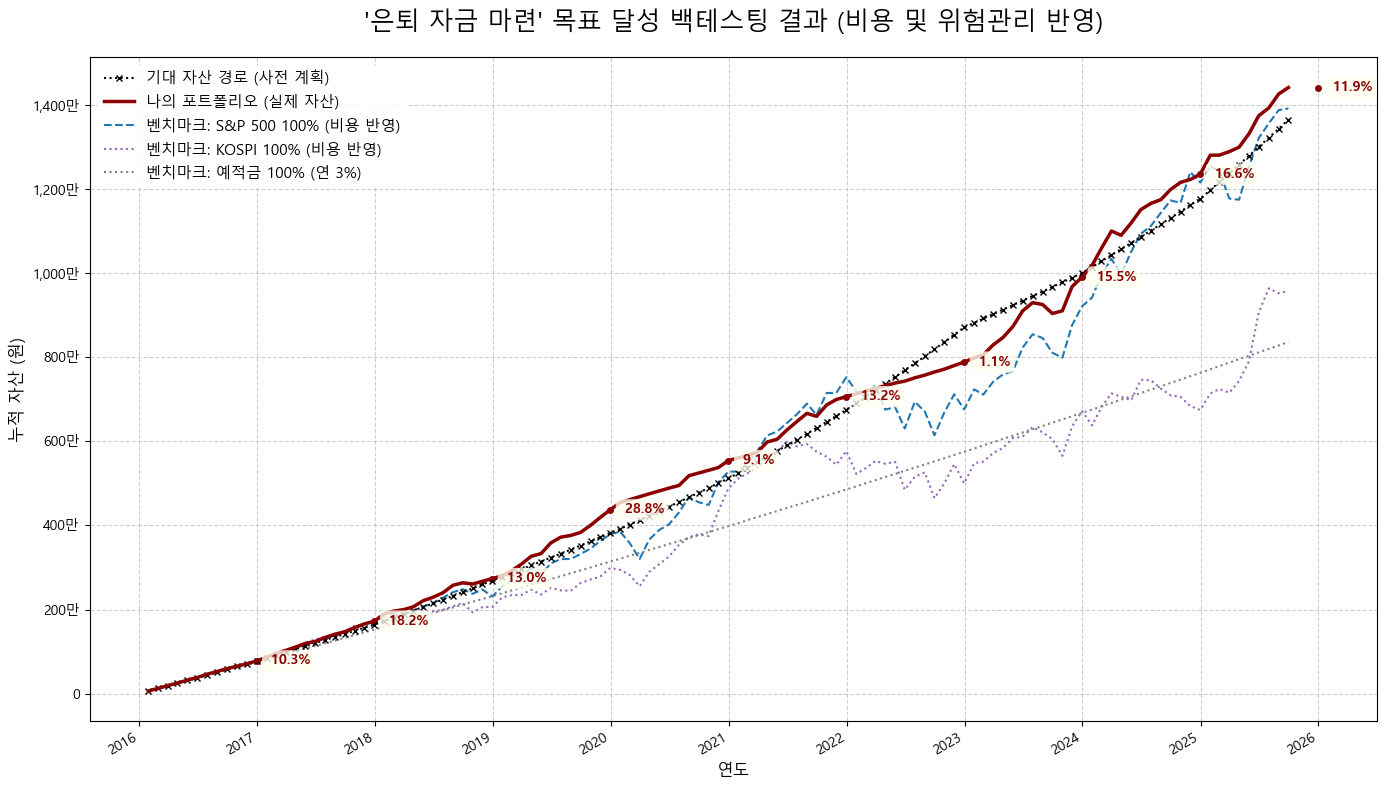

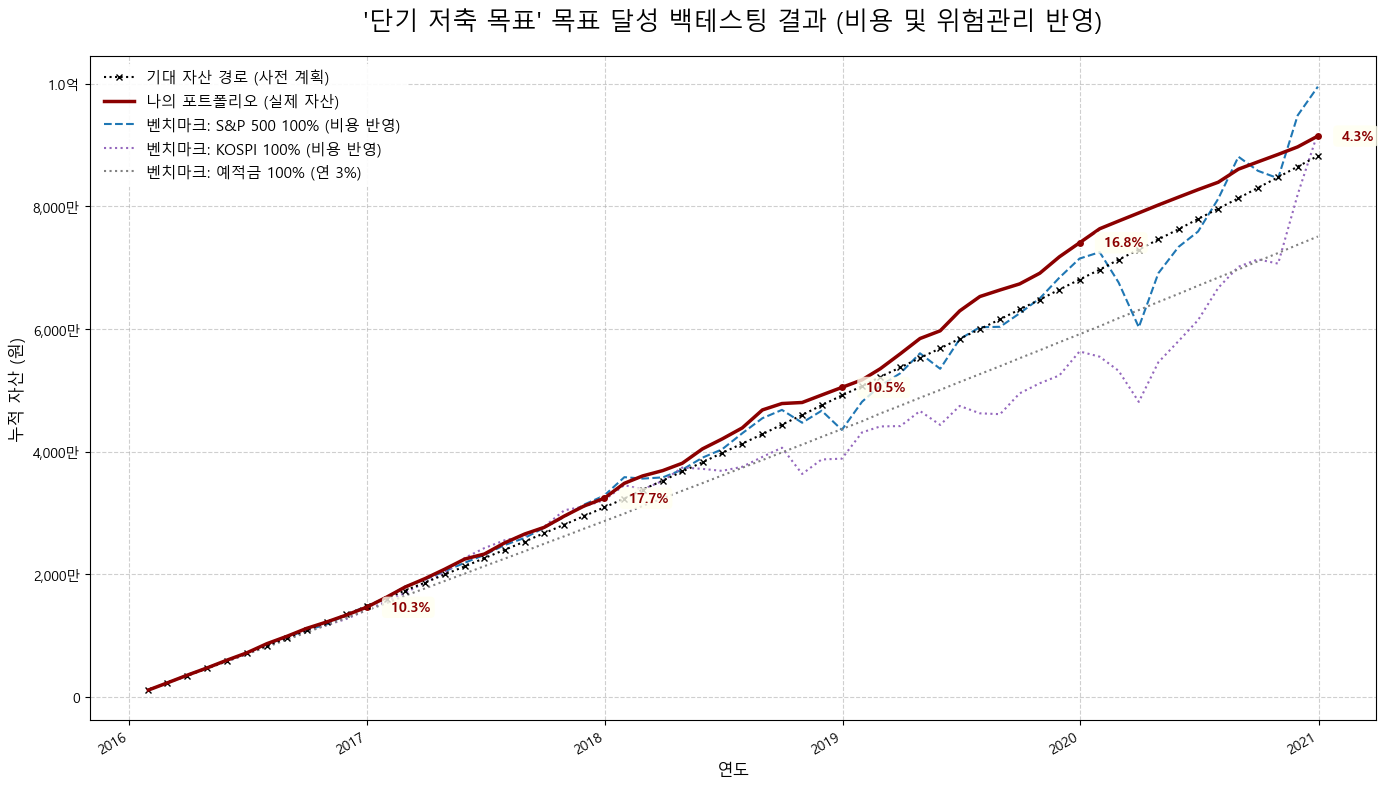

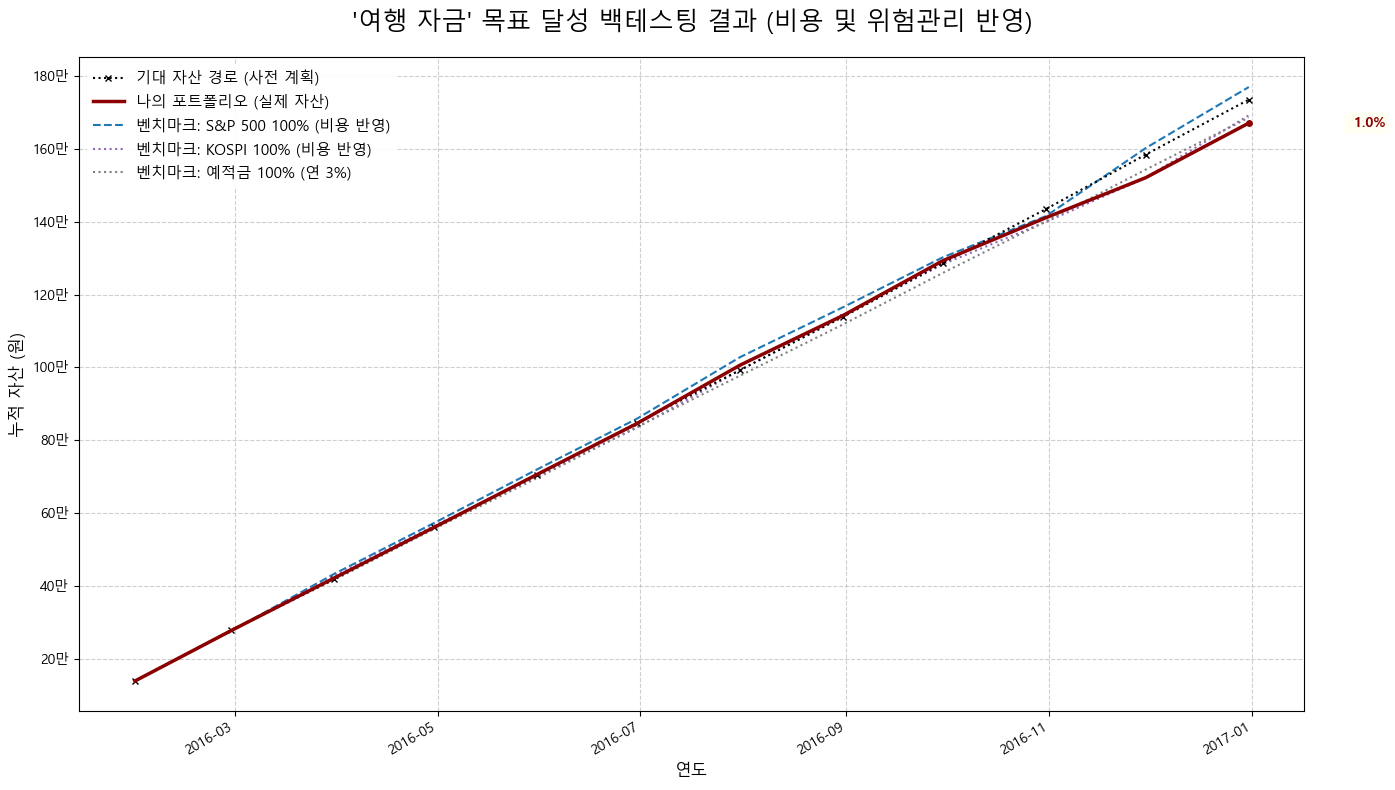

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxpy as cp
import yfinance as yf
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager as fm
import numpy_financial as npf


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# --- 2. 데이터 및 거래 비용 준비 ---
try:
    start_date_for_download = df_merged.index.min() - pd.DateOffset(years=10)
    end_date_for_download = df_merged.index.max()
    
    sp500_df_raw = yf.download('^GSPC', start=start_date_for_download, end=end_date_for_download, interval="1mo", progress=False)
    vix_df_raw = yf.download('^VIX', start=start_date_for_download, end=end_date_for_download, interval="1d", progress=False)

    if not sp500_df_raw.empty:
        sp500_df = sp500_df_raw.droplevel(1, axis=1) if isinstance(sp500_df_raw.columns, pd.MultiIndex) else sp500_df_raw
        sp500_close = sp500_df['Close'].rename('S&P 500 Index')
        sp500_close.index = pd.to_datetime(sp500_close.index).to_period('M').to_timestamp('M')
        df_merged_with_sp500 = df_merged.join(sp500_close, how='left').ffill()
        df_returns_full = df_merged_with_sp500.pct_change().dropna()
        print("✅ S&P 500 지수 데이터가 성공적으로 추가되었습니다.")
    else:
        raise ValueError("S&P 500 데이터가 비어 있습니다.")
        
except Exception as e:
    print(f"⚠️ 데이터 다운로드에 실패했습니다. 오류: {e}")
    df_returns_full = df_merged.pct_change().dropna()

asset_fees = {
    'S&P 500': 0.0003, '나스닥 100': 0.0005, 'GLD': 0.0025,
    'KRX 채권지수 국채 3M~1Y': 0.0005, 'KRX 채권지수 국채 2Y~3Y': 0.0005,
    'KRX 채권지수 국채 3Y~5Y': 0.0005, 'KRX 채권지수 국채 5Y~10Y': 0.0005,
    'KRX 채권지수 회사채 종합': 0.0005, 'KOSPI': 0.0005, 'KOSPI200': 0.0005,
    'KOSDAQ': 0.0005, 'CSI 300': 0.005, '니케이 225': 0.0009, '유로스톡스50': 0.0009,
    'S&P 500 Index': 0.0003
}
asset_names = df_returns_full.columns.tolist()
annual_fees = np.array([asset_fees.get(name, 0.001) for name in asset_names])
monthly_fees = annual_fees / 12
slippage_rate = 0.0005
n_assets = len(asset_names)
is_stock = np.array([0 if '채권' in name else 1 for name in asset_names])
target_vol = vol_limit_map.get(profile, 0.10)
BACKTEST_START_DATE = pd.to_datetime('2016-01-01')

# --- 3. 헬퍼 함수 및 위험 관리 시그널 ---
def korean_currency_formatter(x, pos):
    if x >= 1e8: return f'{x / 1e8:,.1f}억'
    if x >= 1e4: return f'{x / 1e4:,.0f}만'
    return f'{x:,.0f}'

def generate_multifactor_signal(vix_data, market_df, vix_caution=23, vix_danger=30, ma_period=12):
    base_index = market_df.index
    vix_signal = pd.Series(0, index=base_index)
    if not vix_data.empty:
        vix_monthly_max = vix_data['Close'].resample('M').max().reindex(base_index, method='ffill').fillna(0)
        vix_signal[vix_monthly_max > vix_caution] = 1
        vix_signal[vix_monthly_max > vix_danger] = 2
    market_monthly_close = market_df['나스닥 100']
    ma_monthly = market_monthly_close.rolling(window=ma_period).mean()
    ma_signal = pd.Series(0, index=base_index)
    ma_signal[market_monthly_close < ma_monthly] = 2
    combined_signal = pd.DataFrame({'VIX': vix_signal.astype(int), 'MA': ma_signal.astype(int)}).max(axis=1)
    combined_signal.name = "RiskLevel"
    return combined_signal

def calculate_monthly_investment(target_amount, yearly_return_rates):
    years = len(yearly_return_rates)
    if years == 0: return 0
    avg_annual_rate = np.mean(yearly_return_rates)
    if avg_annual_rate > 0:
        monthly_rate = avg_annual_rate / 12
        n_months = years * 12
        required_monthly = -npf.pmt(monthly_rate, n_months, 0, fv=target_amount)
    else:
        required_monthly = target_amount / (years * 12) if years > 0 else 0
    return required_monthly if required_monthly > 0 else 0

# --- 4. 백테스팅 핵심 함수 ---
def run_backtest_with_risk_management(goal, allocation_df, returns_df, risk_signal):
    goal_name, goal_years = goal["재무 목표"], int(goal["기간(년)"])
    print(f"\n--- 🎯 '{goal_name}' 목표 백테스팅 진행 (기간: {goal_years}년) ---")
    monthly_investment = allocation_df.loc[allocation_df['재무 목표'] == goal_name, '월 배분 투자금(원)'].iloc[0]
    if monthly_investment <= 1: return None

    yearly_expected_returns_plan, yearly_weights_plan = [], []
    last_valid_weights = np.zeros(n_assets)
    for year_idx in range(goal_years):
        train_end = BACKTEST_START_DATE + pd.DateOffset(years=year_idx, months=-1)
        train_start = train_end - pd.DateOffset(years=10)
        train_returns = returns_df.loc[train_start:train_end]
        if train_returns.empty or len(train_returns) < 12:
            weights_opt = last_valid_weights
            mu_plan = yearly_expected_returns_plan[-1] if yearly_expected_returns_plan else 0
        else:
            mu_plan = train_returns.ewm(span=60).mean().iloc[-1].values * 12
            cov_plan = train_returns.ewm(span=60).cov().iloc[-n_assets:].values * 12
            stock_limit = tdf_max_stock_ratio(year_idx, goal_years)
            w = cp.Variable(n_assets)
            constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov_plan) <= target_vol**2, is_stock @ w <= stock_limit]
            prob = cp.Problem(cp.Maximize(mu_plan @ w), constraints)
            prob.solve()
            weights_opt = w.value if w.value is not None else np.zeros(n_assets)
            last_valid_weights = weights_opt
        yearly_expected_returns_plan.append(mu_plan @ weights_opt if isinstance(mu_plan, np.ndarray) else mu_plan)
        yearly_weights_plan.append(weights_opt)

    backtest_period = pd.date_range(start=BACKTEST_START_DATE, periods=goal_years * 12, freq='ME')
    path_data = []
    fund_portfolio, fund_sp500, fund_kospi, fund_savings, fund_expected = 0, 0, 0, 0, 0
    previous_weights = np.zeros(n_assets)
    safe_asset_idx = [i for i, name in enumerate(asset_names) if '채권' in name][0]
    safe_asset_weights = np.zeros(n_assets); safe_asset_weights[safe_asset_idx] = 1.0
    sp500_monthly_fee = asset_fees.get('S&P 500 Index', 0) / 12
    kospi_monthly_fee = asset_fees.get('KOSPI', 0) / 12

    for date in backtest_period:
        if date not in returns_df.index: continue
        year_idx = min(date.year - BACKTEST_START_DATE.year, goal_years - 1)
        weights_tdf = yearly_weights_plan[year_idx]
        risk_level = risk_signal.get(date, 0)
        if risk_level == 1: current_weights = (weights_tdf * 0.5) + (safe_asset_weights * 0.5)
        elif risk_level == 2: current_weights = safe_asset_weights
        else: current_weights = weights_tdf
        actual_monthly_returns = returns_df.loc[date].values
        turnover = np.sum(np.abs(current_weights - previous_weights)) / 2
        transaction_cost = fund_portfolio * turnover * slippage_rate
        asset_management_fee = fund_portfolio * np.dot(current_weights, monthly_fees)
        expected_monthly_return = yearly_expected_returns_plan[year_idx] / 12
        fund_expected = fund_expected * (1 + expected_monthly_return) + monthly_investment
        fund_portfolio = fund_portfolio * (1 + np.dot(actual_monthly_returns, current_weights)) + monthly_investment - transaction_cost - asset_management_fee
        fund_sp500 = fund_sp500 * (1 + returns_df.loc[date, 'S&P 500 Index'] - sp500_monthly_fee) + monthly_investment * (1 - slippage_rate)
        fund_kospi = fund_kospi * (1 + returns_df.loc[date, 'KOSPI'] - kospi_monthly_fee) + monthly_investment * (1 - slippage_rate)
        fund_savings = fund_savings * (1 + 0.03 / 12) + monthly_investment
        path_data.append({'Date': date, 'My Portfolio': fund_portfolio, 'S&P 500 Benchmark': fund_sp500, 'KOSPI Benchmark': fund_kospi, 'Savings Benchmark': fund_savings, 'Expected Path': fund_expected})
        previous_weights = current_weights.copy()
            
    path_df = pd.DataFrame(path_data).set_index('Date')
    return {'name': goal_name, 'data': path_df, 'monthly_investment': monthly_investment}

# --- 5. 시각화 함수 (가독성 최종 개선) ---
def plot_backtest_results(results):
    for result in results:
        goal_name = result['name']
        df = result['data']
        monthly_investment = result['monthly_investment']
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        ax.plot(df.index, df['Expected Path'], label="기대 자산 경로 (사전 계획)", color='black', linestyle=':', marker='x', markersize=5, zorder=4)
        ax.plot(df.index, df['My Portfolio'], label="나의 포트폴리오 (실제 자산)", color='darkred', linewidth=2.5, zorder=5)
        if 'S&P 500 Benchmark' in df.columns and df['S&P 500 Benchmark'].sum() > 0:
            ax.plot(df.index, df['S&P 500 Benchmark'], label="벤치마크: S&P 500 100% (비용 반영)", color='tab:blue', linestyle='--')
        if 'KOSPI Benchmark' in df.columns and df['KOSPI Benchmark'].sum() > 0:
            ax.plot(df.index, df['KOSPI Benchmark'], label="벤치마크: KOSPI 100% (비용 반영)", color='tab:purple', linestyle=':')
        ax.plot(df.index, df['Savings Benchmark'], label="벤치마크: 예적금 100% (연 3%)", color='gray', linestyle=':')
        
        yearly_assets = df['My Portfolio'].resample('YE').last()
        previous_year_asset = 0
        for year_end_date, end_of_year_asset in yearly_assets.items():
            # 연말 위치에만 마커 추가
            ax.plot(year_end_date, end_of_year_asset, marker='o', markersize=6, color='darkred', markeredgecolor='white')

            year = year_end_date.year
            year_data = df[df.index.year == year]
            principal_this_year = monthly_investment * len(year_data)
            investment_gain = end_of_year_asset - previous_year_asset - principal_this_year
            denominator = previous_year_asset + (principal_this_year / 2)
            annual_return = investment_gain / denominator if denominator != 0 else 0
            
            # ★★★ 텍스트 박스 zorder 수정 ★★★
            bbox_props = dict(boxstyle='round,pad=0.3', facecolor='ivory', alpha=0.8, edgecolor='none')
            ax.text(year_end_date + pd.DateOffset(days=30), end_of_year_asset, f' {annual_return:.1%}', 
                    ha='left', va='center', fontsize=10, color='darkred', fontweight='bold', bbox=bbox_props, zorder=10)
            
            previous_year_asset = end_of_year_asset

        ax.set_title(f"'{goal_name}' 목표 달성 백테스팅 결과 (비용 및 위험관리 반영)", fontsize=18, pad=20)
        ax.set_xlabel("연도", fontsize=12)
        ax.set_ylabel("누적 자산 (원)", fontsize=12)
        ax.yaxis.set_major_formatter(FuncFormatter(korean_currency_formatter))
        
        # ★★★ 범례 스타일 수정 ★★★
        legend = ax.legend(fontsize=11, frameon=True, framealpha=0.9, facecolor='white', edgecolor='none')
        
        ax.grid(True, linestyle='--', alpha=0.6)
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()

# --- 6. 최종 실행 ---
if not vix_df_raw.empty:
    vix_daily = vix_df_raw.droplevel(1, axis=1) if isinstance(vix_df_raw.columns, pd.MultiIndex) else vix_df_raw
    vix_daily = vix_daily[['Close']]
else:
    vix_daily = pd.DataFrame()
multifactor_signal = generate_multifactor_signal(vix_daily, df_merged_with_sp500)

backtest_target_goals = summary_table_filtered[
    (~summary_table_filtered['재무 목표'].isin(['종합', '현금성 자산 (유동성)', '청년 주택드림 청약통장', '여윳돈 운용'])) &
    (summary_table_filtered['기간(년)'].notna()) &
    (summary_table_filtered['기간(년)'] >= 1)
].reset_index(drop=True)

goal_list_for_backtest = backtest_target_goals.to_dict('records')

if goal_list_for_backtest:
    all_results = []
    for goal in goal_list_for_backtest:
        result = run_backtest_with_risk_management(
            goal=goal,
            allocation_df=summary_table_filtered,
            returns_df=df_returns_full,
            risk_signal=multifactor_signal
        )
        if result:
            all_results.append(result)
    
    if all_results:
        plot_backtest_results(all_results)
else:
    print("⚠️ 백테스팅을 실행할 투자 재무 목표가 없습니다.")

## 향후 개선 방향

1. 현재 투자하고 있는 정보들 반영 (예적금 상품, 투자성 상품)
- 현재 투자하고 있는 것들을 모두 정리하게 할 것인지?
- 현재 예적금 상품을 가입하고 있다면 그것들은 어떻게 처리할 것인지?

2. 투자(ETF) 상품들 수수료 정밀 반영 + 추천
- 수수료, 거래대금, 트레킹에러 등..

3. 청년도약계좌, 예적금 상품 등 우대금리 고민
- 우대금리에서도 사용자가 편하게 할 수 있는 것들이 있고, 어려운 것들이 있음 (어떻게 처리?)

4. UI/UX (엣지?)
- 삼양에 투자했었다면?
- 백테스팅 관련 
    - 백테스팅 관련 애기를 빼고, 실제 사용자 예시를 넣어서 실제 성과랑 비교 (vs 원래 투자비중 or if 우리 서비스 따르지 않았을 때 실제 투자 성과)

5. 공과금 절약 관련 소비 절약에 넣기

6. 재무설계 관련 지식을 얻을 수 있는 탭 (콘텐츠)
- 이런 정보를 알면 더욱 자세한 재무설계가 가능해요

7. Rule 엔진 기반

8. 어펜딕스에 유저 한 명당 한 달 ai 비용 적어놔주면 재밌을 듯 (수익과 비교)
    - 마케팅 수수료도 조사하면 굳


##(핀넥트챌린지 본선 질문)

1. 기존 재무설계 서비스 어플들과의 가장 큰 차이점 (2번 물으심) + 손PB만의 엣지가 뭐냐 (카카오/토스는 편의성 -> 이런 핀테크 어플들은 무조건 편의성을 중요시 보는 듯)
    - 이해를 잘 못 시키는 듯?
    - 더 잘 이해할 수 있는 페이지 구성 필요
        - 어펜딕스에 현존하는 모든 재무설계 서비스 받아본 사진 넣어놓고 비교

2. 백테스팅은 못 믿겠으니 수익 말고 다른 거 어필할 거 있냐?
- (답변) 변동성도 잘 컨트롤 하고 있음   
- 백테스팅의 개념을 제대로 심사위원들이 이해하지 못 하는 것 같음
- 백테스팅 관련 애기를 빼고, 실제 사용자 예시를 넣어서 실제 성과랑 비교 (vs 원래 투자비중 or if 우리 서비스 따르지 않았을 때 실제 투자 성과)

3. 쉽게 락인이 안 될 것 같다? 쉽게 빠져나갈 것 같다? 그런 부분에서 대안이 있는지
- (답변) AI가계부와 AI자산관리를 무료로 풀어두고 해당 부분에서는 개괄적인 얘기 -> 락인 효과를 통해 AI 재무설계로 유도

4. 배당금 등 반영

5. 자산군 업데이트 (지수 등)

6. ETF 등 추천 알고리즘

7. 부채 알고리즘

8. finance 관련 q&a 챗봇